# Mobility data anlaysis (Matt)

In [1]:
# imports and setup
from   ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   scipy.optimize import curve_fit
from   scipy.stats import permutation_test
import seaborn as sns
from   sklearn.preprocessing import LabelBinarizer
import string
import warnings

# locations
data_dir = os.path.join('..', 'data')
derived_dir = os.path.join(data_dir, 'derived')
metadata_dir = os.path.join(data_dir, 'metadata')
fig_dir = os.path.join('..', 'figures')

conlit_file = 'CONLIT_CharData_AP_MW_11.csv.gz'
early_file  = 'EARLY_CharData_AP_MW_11.csv.gz'

conlit_meta_file = 'CONLIT_META.csv'
early_meta_file = 'EARLY_META.tsv'

# settings
vis_formats = [
    'png',
    'svg',
    #'eps'
]

## Load data

In [2]:
def string_to_list(x):
    lst = literal_eval(x.replace(', nan', "', ZZZZ'").replace('[nan, ', "'['").replace(', nan]', "']'"))
    return [i for i in lst if i != 'ZZZZ']

# read CONLIT
conlit = pd.read_csv(
    os.path.join(derived_dir, conlit_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
conlit.replace([np.inf, -np.inf], np.nan, inplace=True)
conlit.rename(columns={'source':'collection'}, inplace=True)
conlit.loc[conlit.inf_gender=='she/her', ['inf_gender']] = 'she/her/hers'

# read EARLY
early = pd.read_csv(
    os.path.join(derived_dir, early_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
early.replace([np.inf, -np.inf], np.nan, inplace=True)
early.loc[early.inf_gender=='she/her', ['inf_gender']] = 'she/her/hers'

## Calculate new features

For narrative perspective, we set `first` if protagonist `char_id` is zero. See [BookNLP code](https://github.com/booknlp/booknlp/blob/2b42ccd40dc2c62097308398d4e08f91ecab4177/booknlp/english/name_coref.py#L339) for full details. In brief, BookNLP assigns all mentions of `I`, `me`, `myself`, and `my` *outside* of quotations to `char_id` zero, which is presumed to be the first-person narrator. If that `char_id` is then the most common one, it will be identified as the protagonist. We then infer that the book is narrated in the first person, otherwise not.

In [3]:
early['dist_miles_norm'] = early.dist_miles.div(early.Tokens)
early['dist_miles_norm_byCharacter'] = early.dist_miles.div(early.char_count)
early['perspective'] = early.char_id.apply(lambda x: 'first' if x==0 else 'other')
conlit['dist_miles_norm'] = conlit.dist_miles.div(conlit.Tokens)
conlit['dist_miles_norm_byCharacter'] = conlit.dist_miles.div(conlit.char_count)
conlit['perspective'] = conlit.char_id.apply(lambda x: 'first' if x==0 else 'other')

## Combine data

Combine EARLY and CONLIT, calculate integrated distance ranks, and write out combined data.

In [4]:
# combine data for easier plotting
data = pd.concat([conlit, early])
data['dist_miles_rank'] = data.dist_miles.rank()
data['non_gpe_total_rank'] = data.nongpe_places_total.rank()
data['gpe_total_rank'] = data.gpe_places_total.rank()

# write to disk
data.to_csv(os.path.join(derived_dir, 'ALL_CharData_AP_MW_11.csv.gz'))

## Corpus stats and vis

In [5]:
# rename collections for better legibility
data.collection.replace(
    to_replace = {
        'conlit':'CONLIT',
        'chicago_1':'Chicago I',
        'chicago_2':'Chicago II',
        'wright':'Wright',
        'eaf':'EAF'
    },
    inplace=True
)

print(f"Volumes in corpus: {len(data)}")
display(data.collection.value_counts())

Volumes in corpus: 13383


collection
Chicago II    6481
CONLIT        2754
Chicago I     2608
Wright        1052
EAF            488
Name: count, dtype: int64

In [6]:
print(f"Volumes in EARLY: {len(data.loc[data.collection!='CONLIT'])}")

Volumes in EARLY: 10629


In [7]:
print(f"Earliest volume: {data.pub_date.min()}; latest volume: {data.pub_date.max()}")

Earliest volume: 1789; latest volume: 2021


In [8]:
print("Date ranges by subcorpus")
data[['collection', 'pub_date']].groupby('collection').describe()

Date ranges by subcorpus


pub_date                                                          \
              count         mean        std     min     25%     50%     75%   
collection                                                                    
CONLIT       2754.0  2013.319172   2.910859  2001.0  2012.0  2014.0  2015.0   
Chicago I    2608.0  1921.407209  16.567741  1880.0  1909.0  1924.0  1936.0   
Chicago II   6481.0  1982.770714  15.263748  1946.0  1974.0  1988.0  1995.0   
EAF           488.0  1835.625000  12.612075  1789.0  1831.0  1838.0  1845.0   
Wright       1052.0  1862.470532   7.850536  1837.0  1855.0  1863.0  1869.0   

                    
               max  
collection          
CONLIT      2021.0  
Chicago I   1945.0  
Chicago II  2000.0  
EAF         1850.0  
Wright      1875.0

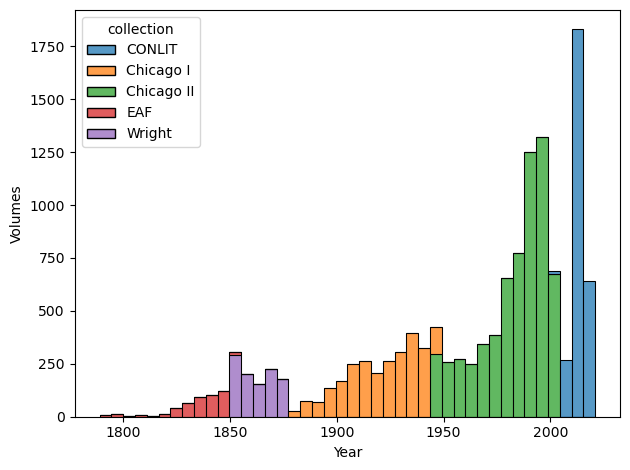

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.histplot(
        x='pub_date', 
        data=data, 
        hue='collection',
        multiple='stack',
        line_kws={'linewidth':0}
    )
    plt.xlabel('Year')
    plt.ylabel('Volumes')
    plt.tight_layout()
    for ext in vis_formats:
        plt.savefig(os.path.join(fig_dir, 'corpus_histogram.'+ext), dpi=300)
    plt.show()

# Feature differences by facet 

### CONLIT

In [10]:
def significance_label(pvalue, levels=[0.05, 0.01, 0.001]):
    if pvalue < levels[2]:
        return '***'
    elif pvalue < levels[1]:
        return '**'
    elif pvalue < levels[0]:
        return '*'
    else: 
        return ''

def diff_means(x, y, axis):
    return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)

def compare_facets(df, facets, cols_to_drop, statistic=diff_means):
    '''Compare statistic in numeric cols of df via permutation. Display results, return nothing.'''
    cols = df.select_dtypes(include='number').drop(columns=cols_to_drop).columns
    for facet in facets:
        print(f"\n==============\nFacet: {facet}\n==============")           
        df = df.dropna(subset=[facet])
        if facet != 'Category': # unless comparing FIC to NON, drop NON
            df = df.loc[df.Category=='FIC']
            
        if facet == 'inf_gender': # only keep she/her and he/him characters when comparing genders
            df = df.loc[df[facet].isin(set(['she/her/hers', 'he/him/his']))]
        elif facet == 'author_gender': # ditto M/F only for authors
            df = df.loc[df[facet].isin(set(['F', 'M']))]
            
        if df[facet].nunique() == 2:
            level1, level2 = df[facet].unique()
            data = (df.loc[df[facet]==level1, cols], df.loc[df[facet]==level2, cols])
            level_mean = np.mean(data[0], axis=0)
            other_mean = np.mean(data[1], axis=0)
            output = pd.DataFrame(level_mean, columns=[level1]).join(pd.DataFrame(other_mean, columns=[level2]))
            res = permutation_test(data, statistic, n_resamples=2500)
            output['diff'] = res.statistic
            output['p'] = res.pvalue
            output['sig'] = output['p'].apply(significance_label)
            display(output)            
        else:
            for level in df[facet].unique():
                data = (df.loc[df[facet]==level, cols], df.loc[~(df[facet]==level), cols])
                level_mean = np.mean(data[0], axis=0)
                other_mean = np.mean(data[1], axis=0)
                output = pd.DataFrame(level_mean, columns=[level]).join(pd.DataFrame(other_mean, columns=['others']))
                res = permutation_test(data, statistic, n_resamples=2500)
                output['diff'] = res.statistic
                output['p'] = res.pvalue
                output['sig'] = output['p'].apply(significance_label)
                display(output)

In [11]:
facet_by = ['Category', 'inf_gender', 'author_gender', 'perspective', 'Genre']
ignore_numeric_cols = ['char_id', 'char_rank', 'num_words']
compare_facets(conlit, facet_by, ignore_numeric_cols, diff_means)


Facet: Category


FIC            NON  \
char_count                             4201.894519    2884.367073   
num_gpe_places                           13.344881      35.776829   
num_nongpe_places                       123.875388     120.786585   
num_all_places                          136.805584     155.698780   
dist_miles                            38024.078670  131262.735676   
Tokens                               121620.681489  142400.906098   
num_gpe_places_norm                       0.000117       0.000263   
num_nongpe_places_norm                    0.001116       0.000970   
num_gpe_places_norm_byCharacter           0.003816       0.018413   
num_nongpe_places_norm_byCharacter        0.033306       0.046310   
char_count_norm                           0.036964       0.022761   
nongpe_places_total                     275.668046     241.345122   
gpe_places_total                         38.888831     126.523171   
ttr_nongpe                                0.483171       0.579897   
ttr_gpe                                   0.434065       0.391032   
avg_Distance_GPE                        868.661990    1042.778946   
non_gpe_ratio                            14.331291       3.989569   
avg_Distance_GPE_Tokens                   0.327338       0.914396   
deixis_count_perplace                     0.109243       0.038252   
semantic_dist_mean                        0.521991       0.504489   
semantic_dist_total                      91.591084      84.194248   
dist_miles_allChars                   91745.375475  294039.950514   
dist_miles_allChars_norm_Tokens           0.756511       1.936208   
num_gpe_places_allChars_norm_Tokens       0.000344       0.000679   
non_gpe_total_rank                     1493.716649    1103.398780   
dist_miles_rank                        1174.250776    1829.852439   
pub_date                               2013.463806    2012.978049   
Start_Finish_Miles                     1854.249567    1942.706982   
Start_Finish_Z                           -1.596047      -0.466106   
first_last_SemanticDist                   0.491751       0.449981   
dist_miles_norm                           0.327338       0.914396   
dist_miles_norm_byCharacter              10.135320      54.641669   

                                              diff         p  sig  
char_count                             1317.527446  0.000800  ***  
num_gpe_places                          -22.431948  0.000800  ***  
num_nongpe_places                         3.088802  0.324670       
num_all_places                          -18.893196  0.000800  ***  
dist_miles                           -93238.657006  0.000800  ***  
Tokens                               -20780.224608  0.000800  ***  
num_gpe_places_norm                      -0.000145  0.000800  ***  
num_nongpe_places_norm                    0.000146  0.000800  ***  
num_gpe_places_norm_byCharacter          -0.014597  0.000800  ***  
num_nongpe_places_norm_byCharacter       -0.013004  0.000800  ***  
char_count_norm                           0.014203  0.000800  ***  
nongpe_places_total                      34.322924  0.000800  ***  
gpe_places_total                        -87.634339  0.000800  ***  
ttr_nongpe                               -0.096726  0.000800  ***  
ttr_gpe                                   0.043033  0.000800  ***  
avg_Distance_GPE                       -174.116956  0.000800  ***  
non_gpe_ratio                            10.341721  0.000800  ***  
avg_Distance_GPE_Tokens                  -0.587058  0.000800  ***  
deixis_count_perplace                     0.070991  0.000800  ***  
semantic_dist_mean                        0.017502  0.000800  ***  
semantic_dist_total                       7.396837  0.003998   **  
dist_miles_allChars                 -202294.575039  0.000800  ***  
dist_miles_allChars_norm_Tokens          -1.179697  0.000800  ***  
num_gpe_places_allChars_norm_Tokens      -0.000335  0.000800  ***  
non_gpe_total_rank                      390.317869  0.000800  ***  
d


Facet: inf_gender


she/her/hers     he/him/his  \
char_count                             3869.822581    4419.452542   
num_gpe_places                           12.211022      13.991525   
num_nongpe_places                       119.575269     126.536441   
num_all_places                          131.372312     140.116949   
dist_miles                            35721.668613   39372.905574   
Tokens                               116767.427419  124867.428814   
num_gpe_places_norm                       0.000112       0.000120   
num_nongpe_places_norm                    0.001117       0.001113   
num_gpe_places_norm_byCharacter           0.003544       0.003949   
num_nongpe_places_norm_byCharacter        0.033896       0.032826   
char_count_norm                           0.035634       0.037855   
nongpe_places_total                     267.598118     280.738136   
gpe_places_total                         36.295699      40.450000   
ttr_nongpe                                0.475910       0.487394   
ttr_gpe                                   0.431249       0.435698   
avg_Distance_GPE                        867.815240     866.634166   
non_gpe_ratio                            14.889263      14.030061   
avg_Distance_GPE_Tokens                   0.326169       0.326810   
deixis_count_perplace                     0.106820       0.110842   
semantic_dist_mean                        0.518529       0.523879   
semantic_dist_total                      88.455784      93.477219   
dist_miles_allChars                   89019.272033   93565.844858   
dist_miles_allChars_norm_Tokens           0.766624       0.748887   
num_gpe_places_allChars_norm_Tokens       0.000344       0.000343   
non_gpe_total_rank                     1500.219086    1488.658475   
dist_miles_rank                        1142.452957    1191.646610   
pub_date                               2013.611559    2013.386441   
Start_Finish_Miles                     1851.254474    1849.394892   
Start_Finish_Z                           -4.621444       0.294762   
first_last_SemanticDist                   0.486589       0.494410   
dist_miles_norm                           0.326169       0.326810   
dist_miles_norm_byCharacter               9.722169      10.281272   

                                             diff         p  sig  
char_count                          -5.496300e+02  0.000800  ***  
num_gpe_places                      -1.780504e+00  0.000800  ***  
num_nongpe_places                   -6.961172e+00  0.005598   **  
num_all_places                      -8.744637e+00  0.003199   **  
dist_miles                          -3.651237e+03  0.133547       
Tokens                              -8.100001e+03  0.003199   **  
num_gpe_places_norm                 -7.332272e-06  0.078369       
num_nongpe_places_norm               3.798993e-06  0.896441       
num_gpe_places_norm_byCharacter     -4.059017e-04  0.007197   **  
num_nongpe_places_norm_byCharacter   1.070398e-03  0.074370       
char_count_norm                     -2.221123e-03  0.004798   **  
nongpe_places_total                 -1.314002e+01  0.067973       
gpe_places_total                    -4.154301e+00  0.020792    *  
ttr_nongpe                          -1.148343e-02  0.016793    *  
ttr_gpe                             -4.449416e-03  0.639744       
avg_Distance_GPE                     1.181074e+00  0.979608       
non_gpe_ratio                        8.592020e-01  0.232707       
avg_Distance_GPE_Tokens             -6.406348e-04  0.986006       
deixis_count_perplace               -4.021925e-03  0.172731       
semantic_dist_mean                  -5.350181e-03  0.018393    *  
semantic_dist_total                 -5.021436e+00  0.030388    *  
dist_miles_allChars                 -4.546573e+03  0.411036       
dist_miles_allChars_norm_Tokens      1.773683e-02  0.641343       
num_gpe_places_allChars_norm_Tokens  6.786817e-07  0.936425       
non_gpe_total_rank                   1.156061e+01  0.743703       
dist_miles_rank   


Facet: author_gender


F              M  \
char_count                             4644.710037    3643.078571   
num_gpe_places                           11.391264      15.770238   
num_nongpe_places                       122.588290     125.415476   
num_all_places                          133.612454     140.714286   
dist_miles                            31076.145753   46890.310138   
Tokens                               113823.980483  132061.921429   
num_gpe_places_norm                       0.000106       0.000130   
num_nongpe_places_norm                    0.001150       0.001068   
num_gpe_places_norm_byCharacter           0.002984       0.004834   
num_nongpe_places_norm_byCharacter        0.030522       0.036738   
char_count_norm                           0.042380       0.030002   
nongpe_places_total                     288.028810     259.541667   
gpe_places_total                         34.311338      44.729762   
ttr_nongpe                                0.453913       0.520544   
ttr_gpe                                   0.424515       0.445455   
avg_Distance_GPE                        800.361704     954.472436   
non_gpe_ratio                            16.432063      11.728380   
avg_Distance_GPE_Tokens                   0.285660       0.379746   
deixis_count_perplace                     0.115910       0.100811   
semantic_dist_mean                        0.512836       0.533583   
semantic_dist_total                      92.078374      90.848095   
dist_miles_allChars                   73760.116134  115293.773435   
dist_miles_allChars_norm_Tokens           0.650001       0.893923   
num_gpe_places_allChars_norm_Tokens       0.000310       0.000386   
non_gpe_total_rank                     1630.141264    1313.042857   
dist_miles_rank                        1096.818773    1270.916667   
pub_date                               2013.822491    2013.020238   
Start_Finish_Miles                     1780.889461    1939.350581   
Start_Finish_Z                           -2.019468      -1.097272   
first_last_SemanticDist                   0.488950       0.496549   
dist_miles_norm                           0.285660       0.379746   
dist_miles_norm_byCharacter               7.825254      12.954121   

                                             diff         p  sig  
char_count                            1001.631466  0.000800  ***  
num_gpe_places                          -4.378974  0.000800  ***  
num_nongpe_places                       -2.827186  0.311076       
num_all_places                          -7.101832  0.021591    *  
dist_miles                          -15814.164384  0.000800  ***  
Tokens                              -18237.940945  0.000800  ***  
num_gpe_places_norm                     -0.000024  0.000800  ***  
num_nongpe_places_norm                   0.000081  0.001599   **  
num_gpe_places_norm_byCharacter         -0.001850  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.006216  0.000800  ***  
char_count_norm                          0.012379  0.000800  ***  
nongpe_places_total                     28.487144  0.000800  ***  
gpe_places_total                       -10.418424  0.000800  ***  
ttr_nongpe                              -0.066631  0.000800  ***  
ttr_gpe                                 -0.020940  0.031987    *  
avg_Distance_GPE                      -154.110733  0.000800  ***  
non_gpe_ratio                            4.703683  0.000800  ***  
avg_Distance_GPE_Tokens                 -0.094085  0.000800  ***  
deixis_count_perplace                    0.015099  0.000800  ***  
semantic_dist_mean                      -0.020747  0.000800  ***  
semantic_dist_total                      1.230279  0.605358       
dist_miles_allChars                 -41533.657302  0.000800  ***  
dist_miles_allChars_norm_Tokens         -0.243922  0.000800  ***  
num_gpe_places_allChars_norm_Tokens     -0.000076  0.000800  ***  
non_gpe_total_rank                     317.098407  0.000800  ***  
dist_miles_rank              


Facet: perspective


other          first  \
char_count                             3297.110643    5097.141675   
num_gpe_places                           11.762908      14.830403   
num_nongpe_places                       107.978925     139.381593   
num_all_places                          119.384615     153.744571   
dist_miles                            31431.100424   44465.024864   
Tokens                               130355.756586  113442.610134   
num_gpe_places_norm                       0.000095       0.000138   
num_nongpe_places_norm                    0.000914       0.001310   
num_gpe_places_norm_byCharacter           0.003987       0.003607   
num_nongpe_places_norm_byCharacter        0.035071       0.031458   
char_count_norm                           0.027834       0.045903   
nongpe_places_total                     227.099052     323.078594   
gpe_places_total                         32.599579      45.041365   
ttr_nongpe                                0.508191       0.458526   
ttr_gpe                                   0.450853       0.416858   
avg_Distance_GPE                        846.395840     889.055209   
non_gpe_ratio                            14.708834      14.017198   
avg_Distance_GPE_Tokens                   0.247911       0.404436   
deixis_count_perplace                     0.101950       0.116493   
semantic_dist_mean                        0.527817       0.516157   
semantic_dist_total                      77.351407     105.462507   
dist_miles_allChars                   93682.158235   90287.783331   
dist_miles_allChars_norm_Tokens           0.713368       0.799701   
num_gpe_places_allChars_norm_Tokens       0.000340       0.000347   
non_gpe_total_rank                     1168.925184    1807.319545   
dist_miles_rank                        1033.741834    1309.954498   
pub_date                               2013.358272    2013.581179   
Start_Finish_Miles                     1813.183818    1886.846023   
Start_Finish_Z                           -1.794261      -1.431164   
first_last_SemanticDist                   0.491812       0.492714   
dist_miles_norm                           0.247911       0.404436   
dist_miles_norm_byCharacter               9.846532      10.296874   

                                             diff         p  sig  
char_count                           -1800.031033  0.000800  ***  
num_gpe_places                          -3.067495  0.000800  ***  
num_nongpe_places                      -31.402667  0.000800  ***  
num_all_places                         -34.359955  0.000800  ***  
dist_miles                          -13033.924440  0.000800  ***  
Tokens                               16913.146451  0.000800  ***  
num_gpe_places_norm                     -0.000043  0.000800  ***  
num_nongpe_places_norm                  -0.000395  0.000800  ***  
num_gpe_places_norm_byCharacter          0.000380  0.005598   **  
num_nongpe_places_norm_byCharacter       0.003614  0.000800  ***  
char_count_norm                         -0.018069  0.000800  ***  
nongpe_places_total                    -95.979542  0.000800  ***  
gpe_places_total                       -12.441787  0.000800  ***  
ttr_nongpe                               0.049665  0.000800  ***  
ttr_gpe                                  0.033995  0.000800  ***  
avg_Distance_GPE                       -42.659369  0.218313       
non_gpe_ratio                            0.691636  0.337465       
avg_Distance_GPE_Tokens                 -0.156525  0.000800  ***  
deixis_count_perplace                   -0.014543  0.000800  ***  
semantic_dist_mean                       0.011660  0.000800  ***  
semantic_dist_total                    -28.111100  0.000800  ***  
dist_miles_allChars                   3394.374904  0.517393       
dist_miles_allChars_norm_Tokens         -0.086332  0.028788    *  
num_gpe_places_allChars_norm_Tokens     -0.000007  0.510996       
non_gpe_total_rank                    -638.394361  0.000800  ***  
dist_miles_rank          


Facet: Genre


YA         others  \
char_count                             5656.602273    4058.811494   
num_gpe_places                           11.539773      13.490230   
num_nongpe_places                       130.767045     123.125862   
num_all_places                          141.875000     136.205172   
dist_miles                            28865.073812   38934.218595   
Tokens                               106003.238636  123419.567241   
num_gpe_places_norm                       0.000114       0.000117   
num_nongpe_places_norm                    0.001257       0.001099   
num_gpe_places_norm_byCharacter           0.002366       0.003940   
num_nongpe_places_norm_byCharacter        0.024401       0.034142   
char_count_norm                           0.053501       0.035279   
nongpe_places_total                     330.079545     270.022989   
gpe_places_total                         36.119318      39.158046   
ttr_nongpe                                0.414910       0.490025   
ttr_gpe                                   0.398016       0.437305   
avg_Distance_GPE                        728.659019     882.012674   
non_gpe_ratio                            16.968793      14.096091   
avg_Distance_GPE_Tokens                   0.288061       0.330838   
deixis_count_perplace                     0.131660       0.107027   
semantic_dist_mean                        0.501987       0.523949   
semantic_dist_total                     101.184966      90.563320   
dist_miles_allChars                   60020.694978   95200.581799   
dist_miles_allChars_norm_Tokens           0.593781       0.773443   
num_gpe_places_allChars_norm_Tokens       0.000301       0.000348   
non_gpe_total_rank                     1950.892045    1444.615517   
dist_miles_rank                        1153.289773    1175.154023   
pub_date                               2014.926136    2013.323563   
Start_Finish_Miles                     1436.774770    1892.194936   
Start_Finish_Z                           -0.752889      -1.696718   
first_last_SemanticDist                   0.518673       0.489487   
dist_miles_norm                           0.288061       0.330838   
dist_miles_norm_byCharacter               6.043016      10.481532   

                                             diff         p  sig  
char_count                            1597.790778  0.000800  ***  
num_gpe_places                          -1.950457  0.015994    *  
num_nongpe_places                        7.641183  0.115154       
num_all_places                           5.669828  0.288685       
dist_miles                          -10069.144784  0.009596   **  
Tokens                              -17416.328605  0.000800  ***  
num_gpe_places_norm                     -0.000004  0.638944       
num_nongpe_places_norm                   0.000158  0.000800  ***  
num_gpe_places_norm_byCharacter         -0.001573  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.009741  0.000800  ***  
char_count_norm                          0.018221  0.000800  ***  
nongpe_places_total                     60.056557  0.000800  ***  
gpe_places_total                        -3.038728  0.327869       
ttr_nongpe                              -0.075115  0.000800  ***  
ttr_gpe                                 -0.039289  0.015994    *  
avg_Distance_GPE                      -153.353655  0.006397   **  
non_gpe_ratio                            2.872702  0.029588    *  
avg_Distance_GPE_Tokens                 -0.042777  0.215914       
deixis_count_perplace                    0.024632  0.000800  ***  
semantic_dist_mean                      -0.021962  0.000800  ***  
semantic_dist_total                     10.621647  0.013595    *  
dist_miles_allChars                 -35179.886820  0.000800  ***  
dist_miles_allChars_norm_Tokens         -0.179663  0.003998   **  
num_gpe_places_allChars_norm_Tokens     -0.000046  0.006397   **  
non_gpe_total_rank                     506.276528  0.000800  ***  
dist_miles_rank             

SF         others  \
char_count                             3816.963303    4255.474676   
num_gpe_places                           12.559633      13.407538   
num_nongpe_places                       114.935780     124.969376   
num_all_places                          126.899083     137.987633   
dist_miles                            30941.681274   38916.670688   
Tokens                               144582.059633  118897.366313   
num_gpe_places_norm                       0.000097       0.000120   
num_nongpe_places_norm                    0.000889       0.001143   
num_gpe_places_norm_byCharacter           0.003720       0.003805   
num_nongpe_places_norm_byCharacter        0.031726       0.033443   
char_count_norm                           0.029121       0.037959   
nongpe_places_total                     232.545872     281.059482   
gpe_places_total                         34.119266      39.489988   
ttr_nongpe                                0.528479       0.477302   
ttr_gpe                                   0.454952       0.430967   
avg_Distance_GPE                        800.336282     876.603492   
non_gpe_ratio                            13.996746      14.407651   
avg_Distance_GPE_Tokens                   0.240555       0.337995   
deixis_count_perplace                     0.112552       0.108871   
semantic_dist_mean                        0.547676       0.518627   
semantic_dist_total                      82.904059      92.647612   
dist_miles_allChars                   75814.526143   94043.043549   
dist_miles_allChars_norm_Tokens           0.552357       0.783206   
num_gpe_places_allChars_norm_Tokens       0.000277       0.000352   
non_gpe_total_rank                     1109.573394    1540.106596   
dist_miles_rank                         955.743119    1201.057126   
pub_date                               2012.940367    2013.538869   
Start_Finish_Miles                     2269.024192    1796.610291   
Start_Finish_Z                           -0.685420      -1.724061   
first_last_SemanticDist                   0.533554       0.487462   
dist_miles_norm                           0.240555       0.337995   
dist_miles_norm_byCharacter               8.563491      10.267724   

                                             diff         p  sig  
char_count                            -438.511373  0.016793    *  
num_gpe_places                          -0.847905  0.254298       
num_nongpe_places                      -10.033596  0.013595    *  
num_all_places                         -11.088550  0.015194    *  
dist_miles                           -7974.989414  0.024790    *  
Tokens                               25684.693320  0.000800  ***  
num_gpe_places_norm                     -0.000023  0.000800  ***  
num_nongpe_places_norm                  -0.000253  0.000800  ***  
num_gpe_places_norm_byCharacter         -0.000084  0.698121       
num_nongpe_places_norm_byCharacter      -0.001716  0.058377       
char_count_norm                         -0.008838  0.000800  ***  
nongpe_places_total                    -48.513610  0.000800  ***  
gpe_places_total                        -5.370722  0.059976       
ttr_nongpe                               0.051176  0.000800  ***  
ttr_gpe                                  0.023985  0.105558       
avg_Distance_GPE                       -76.267210  0.146341       
non_gpe_ratio                           -0.410905  0.730908       
avg_Distance_GPE_Tokens                 -0.097441  0.000800  ***  
deixis_count_perplace                    0.003681  0.408637       
semantic_dist_mean                       0.029049  0.000800  ***  
semantic_dist_total                     -9.743553  0.007997   **  
dist_miles_allChars                 -18228.517406  0.023990    *  
dist_miles_allChars_norm_Tokens         -0.230849  0.000800  ***  
num_gpe_places_allChars_norm_Tokens     -0.000075  0.000800  ***  
non_gpe_total_rank                    -430.533201  0.000800  ***  
dist_miles_rank             

BS         others  \
char_count                             4732.879032    4127.182254   
num_gpe_places                           17.459677      12.694245   
num_nongpe_places                       143.322581     120.929257   
num_all_places                          160.282258     133.223621   
dist_miles                            48957.187351   36381.541297   
Tokens                               155174.580645  116860.504197   
num_gpe_places_norm                       0.000125       0.000116   
num_nongpe_places_norm                    0.001016       0.001129   
num_gpe_places_norm_byCharacter           0.004558       0.003682   
num_nongpe_places_norm_byCharacter        0.034952       0.032994   
char_count_norm                           0.031016       0.037836   
nongpe_places_total                     311.072581     270.256595   
gpe_places_total                         50.020161      37.222422   
ttr_nongpe                                0.499054       0.480757   
ttr_gpe                                   0.439863       0.432779   
avg_Distance_GPE                        938.972800     857.362581   
non_gpe_ratio                            10.622966      14.925754   
avg_Distance_GPE_Tokens                   0.339223       0.325078   
deixis_count_perplace                     0.108939       0.109342   
semantic_dist_mean                        0.519814       0.522247   
semantic_dist_total                     105.492714      89.464351   
dist_miles_allChars                  126305.203528   86863.887393   
dist_miles_allChars_norm_Tokens           0.850054       0.743096   
num_gpe_places_allChars_norm_Tokens       0.000395       0.000336   
non_gpe_total_rank                     1332.032258    1514.774580   
dist_miles_rank                        1273.657258    1158.201439   
pub_date                               2011.790323    2013.720624   
Start_Finish_Miles                     1868.137934    1847.717830   
Start_Finish_Z                           -1.000769      -1.701696   
first_last_SemanticDist                   0.480895       0.494057   
dist_miles_norm                           0.339223       0.325078   
dist_miles_norm_byCharacter              11.636333       9.841502   

                                             diff         p  sig  
char_count                             605.696778  0.000800  ***  
num_gpe_places                           4.765433  0.000800  ***  
num_nongpe_places                       22.393324  0.000800  ***  
num_all_places                          27.058637  0.000800  ***  
dist_miles                           12575.646054  0.001599   **  
Tokens                               38314.076449  0.000800  ***  
num_gpe_places_norm                      0.000009  0.149540       
num_nongpe_places_norm                  -0.000113  0.000800  ***  
num_gpe_places_norm_byCharacter          0.000876  0.000800  ***  
num_nongpe_places_norm_byCharacter       0.001958  0.024790    *  
char_count_norm                         -0.006820  0.000800  ***  
nongpe_places_total                     40.815986  0.001599   **  
gpe_places_total                        12.797739  0.000800  ***  
ttr_nongpe                               0.018297  0.003998   **  
ttr_gpe                                  0.007085  0.616553       
avg_Distance_GPE                        81.610219  0.095162       
non_gpe_ratio                           -4.302788  0.000800  ***  
avg_Distance_GPE_Tokens                  0.014146  0.622951       
deixis_count_perplace                   -0.000403  0.979608       
semantic_dist_mean                      -0.002432  0.454218       
semantic_dist_total                     16.028364  0.001599   **  
dist_miles_allChars                  39441.316135  0.000800  ***  
dist_miles_allChars_norm_Tokens          0.106958  0.061575       
num_gpe_places_allChars_norm_Tokens      0.000059  0.000800  ***  
non_gpe_total_rank                    -182.742322  0.000800  ***  
dist_miles_rank             

NYT         others  \
char_count                             3719.703349    4341.160214   
num_gpe_places                           16.351675      12.462617   
num_nongpe_places                       129.624402     122.210280   
num_all_places                          145.581340     134.255007   
dist_miles                            52104.402460   34076.203684   
Tokens                               118268.789474  122810.589453   
num_gpe_places_norm                       0.000150       0.000108   
num_nongpe_places_norm                    0.001194       0.001092   
num_gpe_places_norm_byCharacter           0.004899       0.003487   
num_nongpe_places_norm_byCharacter        0.037954       0.031934   
char_count_norm                           0.032846       0.038099   
nongpe_places_total                     282.799043     273.514019   
gpe_places_total                         48.894737      36.084112   
ttr_nongpe                                0.494136       0.480052   
ttr_gpe                                   0.427841       0.435329   
avg_Distance_GPE                        962.235994     841.609742   
non_gpe_ratio                            12.343310      14.931847   
avg_Distance_GPE_Tokens                   0.460166       0.289725   
deixis_count_perplace                     0.092939       0.113853   
semantic_dist_mean                        0.530297       0.519598   
semantic_dist_total                      96.897805      90.043690   
dist_miles_allChars                  122780.156301   83371.528246   
dist_miles_allChars_norm_Tokens           1.065603       0.670811   
num_gpe_places_allChars_norm_Tokens       0.000433       0.000318   
non_gpe_total_rank                     1513.921053    1484.759012   
dist_miles_rank                        1416.016746    1105.375167   
pub_date                               2014.949761    2013.058077   
Start_Finish_Miles                     1973.131090    1816.103306   
Start_Finish_Z                           -1.556370      -1.624572   
first_last_SemanticDist                   0.502103       0.489446   
dist_miles_norm                           0.460166       0.289725   
dist_miles_norm_byCharacter              14.317249       8.889737   

                                             diff         p  sig  
char_count                            -621.456864  0.000800  ***  
num_gpe_places                           3.889058  0.000800  ***  
num_nongpe_places                        7.414122  0.032787    *  
num_all_places                          11.326333  0.003199   **  
dist_miles                           18028.198776  0.000800  ***  
Tokens                               -4541.799979  0.195122       
num_gpe_places_norm                      0.000042  0.000800  ***  
num_nongpe_places_norm                   0.000102  0.000800  ***  
num_gpe_places_norm_byCharacter          0.001412  0.000800  ***  
num_nongpe_places_norm_byCharacter       0.006020  0.000800  ***  
char_count_norm                         -0.005253  0.000800  ***  
nongpe_places_total                      9.285024  0.271092       
gpe_places_total                        12.810625  0.000800  ***  
ttr_nongpe                               0.014084  0.008796   **  
ttr_gpe                                 -0.007488  0.526190       
avg_Distance_GPE                       120.626252  0.001599   **  
non_gpe_ratio                           -2.588536  0.000800  ***  
avg_Distance_GPE_Tokens                  0.170441  0.000800  ***  
deixis_count_perplace                   -0.020914  0.000800  ***  
semantic_dist_mean                       0.010699  0.000800  ***  
semantic_dist_total                      6.854115  0.027989    *  
dist_miles_allChars                  39408.628055  0.000800  ***  
dist_miles_allChars_norm_Tokens          0.394792  0.000800  ***  
num_gpe_places_allChars_norm_Tokens      0.000114  0.000800  ***  
non_gpe_total_rank                      29.162041  0.447021       
dist_miles_rank            

MY         others  \
char_count                             4094.965217    4220.671412   
num_gpe_places                           13.247826      13.319692   
num_nongpe_places                       132.034783     122.708185   
num_all_places                          144.900000     135.610913   
dist_miles                            33428.516919   38634.184137   
Tokens                               124692.878261  121427.790629   
num_gpe_places_norm                       0.000109       0.000118   
num_nongpe_places_norm                    0.001111       0.001114   
num_gpe_places_norm_byCharacter           0.003719       0.003805   
num_nongpe_places_norm_byCharacter        0.034123       0.033128   
char_count_norm                           0.034449       0.037295   
nongpe_places_total                     289.978261     273.569988   
gpe_places_total                         34.834783      39.430605   
ttr_nongpe                                0.486349       0.482685   
ttr_gpe                                   0.447760       0.431777   
avg_Distance_GPE                        952.087061     856.444849   
non_gpe_ratio                            12.975515      14.551581   
avg_Distance_GPE_Tokens                   0.272269       0.334362   
deixis_count_perplace                     0.116867       0.108257   
semantic_dist_mean                        0.518997       0.522332   
semantic_dist_total                      97.120213      90.777628   
dist_miles_allChars                   88860.758443   92393.048757   
dist_miles_allChars_norm_Tokens           0.694281       0.765488   
num_gpe_places_allChars_norm_Tokens       0.000342       0.000344   
non_gpe_total_rank                     1493.726087    1490.765718   
dist_miles_rank                        1186.100000    1171.378410   
pub_date                               2013.965217    2013.403321   
Start_Finish_Miles                     1837.361257    1852.134317   
Start_Finish_Z                           -3.211927      -1.385717   
first_last_SemanticDist                   0.487467       0.492974   
dist_miles_norm                           0.272269       0.334362   
dist_miles_norm_byCharacter               9.114243      10.204721   

                                            diff         p sig  
char_count                           -125.706194  0.503798      
num_gpe_places                         -0.071865  0.946821      
num_nongpe_places                       9.326598  0.027989   *  
num_all_places                          9.289087  0.046381   *  
dist_miles                          -5205.667218  0.153539      
Tokens                               3265.087632  0.427829      
num_gpe_places_norm                    -0.000010  0.131148      
num_nongpe_places_norm                 -0.000003  0.913235      
num_gpe_places_norm_byCharacter        -0.000086  0.725310      
num_nongpe_places_norm_byCharacter      0.000995  0.247101      
char_count_norm                        -0.002846  0.019192   *  
nongpe_places_total                    16.408273  0.143143      
gpe_places_total                       -4.595822  0.088764      
ttr_nongpe                              0.003664  0.557377      
ttr_gpe                                 0.015983  0.279888      
avg_Distance_GPE                       95.642212  0.048780   *  
non_gpe_ratio                          -1.576065  0.124750      
avg_Distance_GPE_Tokens                -0.062094  0.042383   *  
deixis_count_perplace                   0.008610  0.055978      
semantic_dist_mean                     -0.003336  0.355858      
semantic_dist_total                     6.342584  0.073571      
dist_miles_allChars                 -3532.290314  0.688525      
dist_miles_allChars_norm_Tokens        -0.071207  0.243103      
num_gpe_places_allChars_norm_Tokens    -0.000002  0.926030      
non_gpe_total_rank                      2.960369  0.983607      
dist_miles_rank                        14.721590  0.781287      
pub_date       

ROM         others  \
char_count                             5964.347826    3992.553540   
num_gpe_places                            7.613527      14.001170   
num_nongpe_places                       108.797101     125.648332   
num_all_places                          116.198068     139.212405   
dist_miles                            20892.495650   40082.531742   
Tokens                               103463.314010  124043.131071   
num_gpe_places_norm                       0.000075       0.000122   
num_nongpe_places_norm                    0.001099       0.001116   
num_gpe_places_norm_byCharacter           0.001397       0.004085   
num_nongpe_places_norm_byCharacter        0.019868       0.034868   
char_count_norm                           0.058578       0.034334   
nongpe_places_total                     272.004831     275.967817   
gpe_places_total                         24.830918      40.580456   
ttr_nongpe                                0.420695       0.490687   
ttr_gpe                                   0.392168       0.438725   
avg_Distance_GPE                        660.077117     893.101274   
non_gpe_ratio                            20.492306      13.650819   
avg_Distance_GPE_Tokens                   0.195351       0.342843   
deixis_count_perplace                     0.147570       0.104653   
semantic_dist_mean                        0.483912       0.526537   
semantic_dist_total                      77.529356      93.235900   
dist_miles_allChars                   43630.213766   97823.990870   
dist_miles_allChars_norm_Tokens           0.400745       0.800084   
num_gpe_places_allChars_norm_Tokens       0.000201       0.000361   
non_gpe_total_rank                     1692.657005    1466.710357   
dist_miles_rank                         898.826087    1206.372147   
pub_date                               2014.386473    2013.359860   
Start_Finish_Miles                     1603.955196    1880.206449   
Start_Finish_Z                           -1.235037      -1.654495   
first_last_SemanticDist                   0.455287       0.496621   
dist_miles_norm                           0.195351       0.342843   
dist_miles_norm_byCharacter               3.564008      10.862309   

                                             diff         p  sig  
char_count                            1971.794286  0.000800  ***  
num_gpe_places                          -6.387644  0.000800  ***  
num_nongpe_places                      -16.851231  0.000800  ***  
num_all_places                         -23.014337  0.000800  ***  
dist_miles                          -19190.036092  0.000800  ***  
Tokens                              -20579.817061  0.000800  ***  
num_gpe_places_norm                     -0.000047  0.000800  ***  
num_nongpe_places_norm                  -0.000017  0.672531       
num_gpe_places_norm_byCharacter         -0.002688  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.015001  0.000800  ***  
char_count_norm                          0.024244  0.000800  ***  
nongpe_places_total                     -3.962987  0.770092       
gpe_places_total                       -15.749539  0.000800  ***  
ttr_nongpe                              -0.069992  0.000800  ***  
ttr_gpe                                 -0.046557  0.001599   **  
avg_Distance_GPE                      -233.024156  0.000800  ***  
non_gpe_ratio                            6.841487  0.000800  ***  
avg_Distance_GPE_Tokens                 -0.147492  0.000800  ***  
deixis_count_perplace                    0.042917  0.000800  ***  
semantic_dist_mean                      -0.042626  0.000800  ***  
semantic_dist_total                    -15.706545  0.000800  ***  
dist_miles_allChars                 -54193.777104  0.000800  ***  
dist_miles_allChars_norm_Tokens         -0.399338  0.000800  ***  
num_gpe_places_allChars_norm_Tokens     -0.000160  0.000800  ***  
non_gpe_total_rank                     225.946648  0.000800  ***  
dist_miles_rank            

PW         others  \
char_count                             3185.085938    4362.959036   
num_gpe_places                           14.812500      13.079518   
num_nongpe_places                       121.613281     124.169277   
num_all_places                          135.976562     136.841566   
dist_miles                            49134.962572   36293.519836   
Tokens                               122486.812500  121716.863253   
num_gpe_places_norm                       0.000134       0.000114   
num_nongpe_places_norm                    0.001108       0.001115   
num_gpe_places_norm_byCharacter           0.005177       0.003582   
num_nongpe_places_norm_byCharacter        0.042256       0.031858   
char_count_norm                           0.027561       0.038402   
nongpe_places_total                     259.597656     277.998193   
gpe_places_total                         42.367188      38.340964   
ttr_nongpe                                0.509417       0.479070   
ttr_gpe                                   0.462003       0.429330   
avg_Distance_GPE                       1021.589771     844.228348   
non_gpe_ratio                            12.142340      14.706934   
avg_Distance_GPE_Tokens                   0.442658       0.309058   
deixis_count_perplace                     0.087726       0.112616   
semantic_dist_mean                        0.531394       0.520473   
semantic_dist_total                      89.547556      91.846118   
dist_miles_allChars                  121557.580231   87405.972353   
dist_miles_allChars_norm_Tokens           1.010014       0.717912   
num_gpe_places_allChars_norm_Tokens       0.000396       0.000335   
non_gpe_total_rank                     1368.582031    1510.018675   
dist_miles_rank                        1325.539062    1149.643976   
pub_date                               2010.671875    2013.902410   
Start_Finish_Miles                     2152.926079    1803.700284   
Start_Finish_Z                           -0.500114      -1.782177   
first_last_SemanticDist                   0.487425       0.493033   
dist_miles_norm                           0.442658       0.309058   
dist_miles_norm_byCharacter              15.056938       9.305337   

                                             diff         p  sig  
char_count                           -1177.873099  0.000800  ***  
num_gpe_places                           1.732982  0.019192    *  
num_nongpe_places                       -2.555996  0.522191       
num_all_places                          -0.865004  0.835666       
dist_miles                           12841.442736  0.001599   **  
Tokens                                 769.949247  0.835666       
num_gpe_places_norm                      0.000020  0.002399   **  
num_nongpe_places_norm                  -0.000007  0.807677       
num_gpe_places_norm_byCharacter          0.001595  0.000800  ***  
num_nongpe_places_norm_byCharacter       0.010398  0.000800  ***  
char_count_norm                         -0.010840  0.000800  ***  
nongpe_places_total                    -18.400537  0.063175       
gpe_places_total                         4.026224  0.131148       
ttr_nongpe                               0.030347  0.000800  ***  
ttr_gpe                                  0.032673  0.011995    *  
avg_Distance_GPE                       177.361423  0.000800  ***  
non_gpe_ratio                           -2.564594  0.007997   **  
avg_Distance_GPE_Tokens                  0.133599  0.000800  ***  
deixis_count_perplace                   -0.024889  0.000800  ***  
semantic_dist_mean                       0.010921  0.001599   **  
semantic_dist_total                     -2.298562  0.497401       
dist_miles_allChars                  34151.607877  0.000800  ***  
dist_miles_allChars_norm_Tokens          0.292102  0.000800  ***  
num_gpe_places_allChars_norm_Tokens      0.000061  0.001599   **  
non_gpe_total_rank                    -141.436643  0.004798   **  
dist_miles_rank             

MID         others  \
char_count                            3127.607362    4305.815174   
num_gpe_places                           7.085890      13.889903   
num_nongpe_places                       94.687117     126.537365   
num_all_places                         101.472393     140.003993   
dist_miles                           15259.970781   40124.596754   
Tokens                               85022.184049  125241.301198   
num_gpe_places_norm                      0.000089       0.000120   
num_nongpe_places_norm                   0.001237       0.001102   
num_gpe_places_norm_byCharacter          0.002427       0.003922   
num_nongpe_places_norm_byCharacter       0.031779       0.033384   
char_count_norm                          0.039947       0.036675   
nongpe_places_total                    210.625767     281.575585   
gpe_places_total                        23.656442      40.294353   
ttr_nongpe                               0.477091       0.483686   
ttr_gpe                                  0.437854       0.433309   
avg_Distance_GPE                       662.612725     887.016638   
non_gpe_ratio                           21.406663      13.740634   
avg_Distance_GPE_Tokens                  0.186262       0.339987   
deixis_count_perplace                    0.097802       0.110358   
semantic_dist_mean                       0.528373       0.521333   
semantic_dist_total                     70.743655      93.472627   
dist_miles_allChars                  36119.512830   97162.107276   
dist_miles_allChars_norm_Tokens          0.416810       0.788566   
num_gpe_places_allChars_norm_Tokens      0.000271       0.000350   
non_gpe_total_rank                    1621.392638    1479.007986   
dist_miles_rank                        800.343558    1207.810040   
pub_date                              2013.907975    2013.430120   
Start_Finish_Miles                    1251.190307    1906.073889   
Start_Finish_Z                          -4.784675      -1.320166   
first_last_SemanticDist                  0.460953       0.494817   
dist_miles_norm                          0.186262       0.339987   
dist_miles_norm_byCharacter              4.981604      10.547310   

                                             diff         p  sig  
char_count                           -1178.207812  0.000800  ***  
num_gpe_places                          -6.804013  0.000800  ***  
num_nongpe_places                      -31.850248  0.000800  ***  
num_all_places                         -38.531601  0.000800  ***  
dist_miles                          -24864.625973  0.000800  ***  
Tokens                              -40219.117149  0.000800  ***  
num_gpe_places_norm                     -0.000030  0.000800  ***  
num_nongpe_places_norm                   0.000135  0.001599   **  
num_gpe_places_norm_byCharacter         -0.001495  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.001605  0.122351       
char_count_norm                          0.003273  0.027989    *  
nongpe_places_total                    -70.949818  0.000800  ***  
gpe_places_total                       -16.637911  0.000800  ***  
ttr_nongpe                              -0.006596  0.422231       
ttr_gpe                                  0.004546  0.762095       
avg_Distance_GPE                      -224.403913  0.000800  ***  
non_gpe_ratio                            7.666029  0.000800  ***  
avg_Distance_GPE_Tokens                 -0.153725  0.000800  ***  
deixis_count_perplace                   -0.012557  0.018393    *  
semantic_dist_mean                       0.007040  0.086365       
semantic_dist_total                    -22.728972  0.000800  ***  
dist_miles_allChars                 -61042.594446  0.000800  ***  
dist_miles_allChars_norm_Tokens         -0.371756  0.000800  ***  
num_gpe_places_allChars_norm_Tokens     -0.000079  0.000800  ***  
non_gpe_total_rank                     142.384652  0.010396    *  
dist_miles_rank                       -407.466482  0.000800

### EARLY

In [12]:
facet_by = ['inf_gender', 'author_gender', 'perspective', 'collection']
ignore_numeric_cols = ['char_id', 'char_rank']
compare_facets(early, facet_by, ignore_numeric_cols, diff_means)


Facet: inf_gender


she/her/hers     he/him/his         diff  \
pub_date                              1952.996391    1947.551462     5.444929   
char_count                            3148.029474    2828.611755   319.417719   
num_gpe_places                          10.821955      11.499034    -0.677079   
num_nongpe_places                       98.030075      90.826021     7.204054   
num_all_places                         108.525714     102.010624     6.515091   
dist_miles                           28650.166432   29792.350672 -1142.184240   
Tokens                              119375.848120  114162.008002  5213.840118   
num_gpe_places_norm                      0.000096       0.000106    -0.000011   
num_nongpe_places_norm                   0.000880       0.000851     0.000028   
num_gpe_places_norm_byCharacter          0.003715       0.004595    -0.000880   
num_nongpe_places_norm_byCharacter       0.033425       0.034077    -0.000652   
char_count_norm                          0.027166       0.025698     0.001468   
nongpe_places_total                    209.862857     183.138383    26.724474   
gpe_places_total                        32.068872      32.690259    -0.621387   
ttr_nongpe                               0.506762       0.542036    -0.035273   
ttr_gpe                                  0.442603       0.461253    -0.018650   
avg_Distance_GPE                       753.070149     777.735604   -24.665454   
avg_Distance_GPE_Tokens                  0.237481       0.254140    -0.016659   
non_gpe_ratio                           13.779667      11.532272     2.247395   
non_gpe_total_rank                    5667.690226    5167.190811   500.499414   
dist_miles_rank                       5107.409323    5220.248896  -112.839573   
deixis_count_perplace                    0.103859       0.102079     0.001780   
Start_Finish_Miles                    2328.435429    2414.678305   -86.242876   
Start_Finish_Z                          -8.714638      -2.813063    -5.901575   
semantic_dist_total                     68.339825      62.496479     5.843347   
semantic_dist_mean                       0.506924       0.524440    -0.017516   
first_last_SemanticDist                  0.464446       0.481828    -0.017383   
dist_miles_norm                          0.237481       0.254140    -0.016659   
dist_miles_norm_byCharacter              8.700676      10.342577    -1.641901   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.001599   **  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.256697       
Tokens                              0.001599   **  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.006397   **  
num_gpe_places_norm_byCharacter     0.000800  ***  
num_nongpe_places_norm_byCharacter  0.016793    *  
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.475810       
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.107957       
avg_Distance_GPE_Tokens             0.030388    *  
non_gpe_ratio                       0.000800  ***  
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.092763       
deixis_count_perplace               0.245502       
Start_Finish_Miles                  0.162335       
Start_Finish_Z                      0.379048       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.000800  ***  
first_last_SemanticDist             0.007997   **  
dist_miles_norm                     0.030388    *  
dist_miles_norm_byCharacter         0.000800  ***


Facet: author_gender


M              F         diff  \
pub_date                              1945.623955    1957.993862   -12.369907   
char_count                            2763.582915    3275.017881  -511.434966   
num_gpe_places                          11.805138      10.569255     1.235882   
num_nongpe_places                       89.594315     101.107286   -11.512971   
num_all_places                         101.076455     111.358153   -10.281698   
dist_miles                           30345.184534   28449.059648  1896.124886   
Tokens                              114053.214014  120460.216173 -6407.002159   
num_gpe_places_norm                      0.000109       0.000092     0.000017   
num_nongpe_places_norm                   0.000841       0.000900    -0.000059   
num_gpe_places_norm_byCharacter          0.004768       0.003510     0.001258   
num_nongpe_places_norm_byCharacter       0.034427       0.032832     0.001594   
char_count_norm                          0.025202       0.028048    -0.002846   
nongpe_places_total                    178.725186     218.506805   -39.781619   
gpe_places_total                        32.851649      32.572458     0.279191   
ttr_nongpe                               0.546220       0.501829     0.044391   
ttr_gpe                                  0.464894       0.435448     0.029446   
avg_Distance_GPE                       782.465319     750.364037    32.101282   
avg_Distance_GPE_Tokens                  0.260528       0.231304     0.029224   
non_gpe_ratio                           11.278324      13.953923    -2.675599   
non_gpe_total_rank                    5079.932361    5807.093675  -727.161314   
dist_miles_rank                       5272.558900    5071.907126   200.651774   
deixis_count_perplace                    0.099058       0.109324    -0.010266   
Start_Finish_Miles                    2410.243404    2356.854440    53.388964   
Start_Finish_Z                          -5.695424      -3.043393    -2.652031   
semantic_dist_total                     61.171178      71.451931   -10.280754   
semantic_dist_mean                       0.524588       0.510783     0.013805   
first_last_SemanticDist                  0.480793       0.468823     0.011970   
dist_miles_norm                          0.260528       0.231304     0.029224   
dist_miles_norm_byCharacter             10.708956       8.353849     2.355107   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.000800  ***  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.060776       
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.000800  ***  
num_gpe_places_norm_byCharacter     0.000800  ***  
num_nongpe_places_norm_byCharacter  0.000800  ***  
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.738904       
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.027189    *  
avg_Distance_GPE_Tokens             0.000800  ***  
non_gpe_ratio                       0.000800  ***  
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.003998   **  
deixis_count_perplace               0.000800  ***  
Start_Finish_Miles                  0.370252       
Start_Finish_Z                      0.824470       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.000800  ***  
first_last_SemanticDist             0.047181    *  
dist_miles_norm                     0.000800  ***  
dist_miles_norm_byCharacter         0.000800  ***


Facet: perspective


other          first  \
pub_date                              1955.288133    1939.643443   
char_count                            2818.873517    3212.730679   
num_gpe_places                          10.095369      13.908080   
num_nongpe_places                       88.367873     104.703747   
num_all_places                          98.158900     118.256148   
dist_miles                           25391.601252   38285.606235   
Tokens                              121589.599855  105836.179742   
num_gpe_places_norm                      0.000087       0.000136   
num_nongpe_places_norm                   0.000779       0.001030   
num_gpe_places_norm_byCharacter          0.004004       0.004935   
num_nongpe_places_norm_byCharacter       0.033590       0.034369   
char_count_norm                          0.024071       0.030613   
nongpe_places_total                    181.358611     217.034543   
gpe_places_total                        29.237916      39.855386   
ttr_nongpe                               0.528159       0.534062   
ttr_gpe                                  0.448610       0.465535   
avg_Distance_GPE                       739.517151     834.130523   
avg_Distance_GPE_Tokens                  0.204411       0.341988   
non_gpe_ratio                           12.951710      10.852052   
non_gpe_total_rank                    4921.997685    6197.028981   
dist_miles_rank                       4786.363821    6035.956382   
deixis_count_perplace                    0.103045       0.102255   
Start_Finish_Miles                    2423.317804    2335.905783   
Start_Finish_Z                          -6.509598      -1.812324   
semantic_dist_total                     60.439858      73.927443   
semantic_dist_mean                       0.519748       0.519236   
first_last_SemanticDist                  0.472788       0.483421   
dist_miles_norm                          0.204411       0.341988   
dist_miles_norm_byCharacter              8.951892      11.679894   

                                            diff         p  sig  
pub_date                               15.644691  0.000800  ***  
char_count                           -393.857163  0.000800  ***  
num_gpe_places                         -3.812711  0.000800  ***  
num_nongpe_places                     -16.335874  0.000800  ***  
num_all_places                        -20.097247  0.000800  ***  
dist_miles                         -12894.004983  0.000800  ***  
Tokens                              15753.420113  0.000800  ***  
num_gpe_places_norm                    -0.000049  0.000800  ***  
num_nongpe_places_norm                 -0.000251  0.000800  ***  
num_gpe_places_norm_byCharacter        -0.000931  0.000800  ***  
num_nongpe_places_norm_byCharacter     -0.000779  0.001599   **  
char_count_norm                        -0.006542  0.000800  ***  
nongpe_places_total                   -35.675933  0.000800  ***  
gpe_places_total                      -10.617470  0.000800  ***  
ttr_nongpe                             -0.005904  0.010396    *  
ttr_gpe                                -0.016925  0.000800  ***  
avg_Distance_GPE                      -94.613372  0.000800  ***  
avg_Distance_GPE_Tokens                -0.137576  0.000800  ***  
non_gpe_ratio                           2.099658  0.000800  ***  
non_gpe_total_rank                  -1275.031297  0.000800  ***  
dist_miles_rank                     -1249.592561  0.000800  ***  
deixis_count_perplace                   0.000789  0.642143       
Start_Finish_Miles                     87.412021  0.152739       
Start_Finish_Z                         -4.697274  0.340664       
semantic_dist_total                   -13.487585  0.000800  ***  
semantic_dist_mean                      0.000512  0.667733       
first_last_SemanticDist                -0.010633  0.082367       
dist_miles_norm                        -0.137576  0.000800  ***  
dist_miles_norm_byCharacter            -2.728003  0.000800  ***


Facet: collection


chicago_1         others  \
pub_date                              1921.400548    1959.547864   
char_count                            2394.087706    3131.575399   
num_gpe_places                           8.424041      12.320381   
num_nongpe_places                       73.238058     100.519815   
num_all_places                          81.436179     112.487519   
dist_miles                           21169.572940   32446.282329   
Tokens                              101652.092404  121217.329002   
num_gpe_places_norm                      0.000087       0.000108   
num_nongpe_places_norm                   0.000769       0.000893   
num_gpe_places_norm_byCharacter          0.004142       0.004367   
num_nongpe_places_norm_byCharacter       0.033261       0.034041   
char_count_norm                          0.024239       0.026891   
nongpe_places_total                    150.879405     207.055069   
gpe_places_total                        24.513312      35.457154   
ttr_nongpe                               0.532623       0.529287   
ttr_gpe                                  0.457942       0.452982   
avg_Distance_GPE                       729.544845     784.379291   
avg_Distance_GPE_Tokens                  0.203721       0.265106   
non_gpe_ratio                           13.630246      11.805561   
non_gpe_total_rank                    4815.679327    5517.345600   
dist_miles_rank                       4727.751762    5354.853706   
deixis_count_perplace                    0.099957       0.103712   
Start_Finish_Miles                    2428.190591    2380.173578   
Start_Finish_Z                         -11.410002      -2.920402   
semantic_dist_total                     48.262906      70.369545   
semantic_dist_mean                       0.511344       0.522284   
first_last_SemanticDist                  0.460320       0.481555   
dist_miles_norm                          0.203721       0.265106   
dist_miles_norm_byCharacter              8.982596      10.140831   

                                            diff         p  sig  
pub_date                              -38.147316  0.000800  ***  
char_count                           -737.487693  0.000800  ***  
num_gpe_places                         -3.896340  0.000800  ***  
num_nongpe_places                     -27.281757  0.000800  ***  
num_all_places                        -31.051341  0.000800  ***  
dist_miles                         -11276.709389  0.000800  ***  
Tokens                             -19565.236597  0.000800  ***  
num_gpe_places_norm                    -0.000021  0.000800  ***  
num_nongpe_places_norm                 -0.000124  0.000800  ***  
num_gpe_places_norm_byCharacter        -0.000225  0.009596   **  
num_nongpe_places_norm_byCharacter     -0.000780  0.007197   **  
char_count_norm                        -0.002653  0.000800  ***  
nongpe_places_total                   -56.175665  0.000800  ***  
gpe_places_total                      -10.943841  0.000800  ***  
ttr_nongpe                              0.003337  0.161535       
ttr_gpe                                 0.004960  0.316673       
avg_Distance_GPE                      -54.834446  0.000800  ***  
avg_Distance_GPE_Tokens                -0.061385  0.000800  ***  
non_gpe_ratio                           1.824685  0.000800  ***  
non_gpe_total_rank                   -701.666273  0.000800  ***  
dist_miles_rank                      -627.101944  0.000800  ***  
deixis_count_perplace                  -0.003755  0.026389    *  
Start_Finish_Miles                     48.017013  0.482207       
Start_Finish_Z                         -8.489600  0.208717       
semantic_dist_total                   -22.106639  0.000800  ***  
semantic_dist_mean                     -0.010940  0.000800  ***  
first_last_SemanticDist                -0.021234  0.001599   **  
dist_miles_norm                        -0.061385  0.000800  ***  
dist_miles_norm_byCharacter            -1.158235  0.000800  ***

chicago_2        others          diff  \
pub_date                              1982.788069   1897.498231     85.289839   
char_count                            3481.469074   2092.049039   1389.420034   
num_gpe_places                          13.807535      7.410263      6.397272   
num_nongpe_places                      113.278022     62.363246     50.914776   
num_all_places                         126.669702     69.604398     57.065303   
dist_miles                           37043.119672  17764.136310  19278.983363   
Tokens                              127461.787441  98531.076593  28930.710849   
num_gpe_places_norm                      0.000117      0.000081      0.000037   
num_nongpe_places_norm                   0.000976      0.000680      0.000296   
num_gpe_places_norm_byCharacter          0.004386      0.004192      0.000194   
num_nongpe_places_norm_byCharacter       0.034687      0.032497      0.002191   
char_count_norm                          0.028988      0.021802      0.007186   
nongpe_places_total                    235.047253    125.714611    109.332642   
gpe_places_total                        40.392622     20.444641     19.947981   
ttr_nongpe                               0.516889      0.551404     -0.034515   
ttr_gpe                                  0.438446      0.479591     -0.041145   
avg_Distance_GPE                       820.498290    690.818825    129.679464   
avg_Distance_GPE_Tokens                  0.296746      0.174529      0.122217   
non_gpe_ratio                           11.831500     12.965621     -1.134120   
non_gpe_total_rank                    6133.880220   4071.597068   2062.283152   
dist_miles_rank                       5774.998430   4273.473458   1501.524972   
deixis_count_perplace                    0.105661      0.098151      0.007510   
Start_Finish_Miles                    2399.775343   2375.256993     24.518350   
Start_Finish_Z                          -2.239665    -10.255012      8.015347   
semantic_dist_total                     80.562881     39.684028     40.878852   
semantic_dist_mean                       0.528639      0.504989      0.023649   
first_last_SemanticDist                  0.484878      0.461426      0.023453   
dist_miles_norm                          0.296746      0.174529      0.122217   
dist_miles_norm_byCharacter             10.739081      8.429764      2.309317   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.000800  ***  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.000800  ***  
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.000800  ***  
num_gpe_places_norm_byCharacter     0.015994    *  
num_nongpe_places_norm_byCharacter  0.000800  ***  
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.000800  ***  
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.000800  ***  
avg_Distance_GPE_Tokens             0.000800  ***  
non_gpe_ratio                       0.000800  ***  
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.000800  ***  
deixis_count_perplace               0.000800  ***  
Start_Finish_Miles                  0.694922       
Start_Finish_Z                      0.089564       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.000800  ***  
first_last_SemanticDist             0.000800  ***  
dist_miles_norm                     0.000800  ***  
dist_miles_norm_byCharacter         0.000800  ***

eaf         others          diff  \
pub_date                             1836.204348    1955.423576   -119.219228   
char_count                           1287.102174    3026.660957  -1739.558783   
num_gpe_places                          5.858696      11.613014     -5.754319   
num_nongpe_places                      37.632609      96.389520    -58.756911   
num_all_places                         43.458696     107.667748    -64.209052   
dist_miles                          13302.267721   30419.678938 -17117.411217   
Tokens                              87988.073913  117701.805291 -29713.731378   
num_gpe_places_norm                     0.000069       0.000105     -0.000036   
num_nongpe_places_norm                  0.000485       0.000880     -0.000395   
num_gpe_places_norm_byCharacter         0.005030       0.004278      0.000751   
num_nongpe_places_norm_byCharacter      0.032907       0.033892     -0.000985   
char_count_norm                         0.015888       0.026718     -0.010829   
nongpe_places_total                    65.954348     199.091729   -133.137381   
gpe_places_total                       14.073913      33.621123    -19.547210   
ttr_nongpe                              0.623102       0.525776      0.097326   
ttr_gpe                                 0.543715       0.450036      0.093679   
avg_Distance_GPE                      642.329116     776.807418   -134.478302   
avg_Distance_GPE_Tokens                 0.125359       0.255731     -0.130373   
non_gpe_ratio                           9.906467      12.350994     -2.444527   
non_gpe_total_rank                   2312.852174    5485.114839  -3172.262665   
dist_miles_rank                      3665.245652    5271.294141  -1606.048489   
deixis_count_perplace                   0.071861       0.104225     -0.032365   
Start_Finish_Miles                   2208.906607    2398.780620   -189.874013   
Start_Finish_Z                         -5.163811      -4.732055     -0.431756   
semantic_dist_total                    22.117948      66.896545    -44.778597   
semantic_dist_mean                      0.525663       0.519295      0.006368   
first_last_SemanticDist                 0.465514       0.476911     -0.011397   
dist_miles_norm                         0.125359       0.255731     -0.130373   
dist_miles_norm_byCharacter             8.930412       9.897436     -0.967024   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.000800  ***  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.000800  ***  
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.000800  ***  
num_gpe_places_norm_byCharacter     0.001599   **  
num_nongpe_places_norm_byCharacter  0.079968       
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.000800  ***  
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.000800  ***  
avg_Distance_GPE_Tokens             0.000800  ***  
non_gpe_ratio                       0.000800  ***  
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.000800  ***  
deixis_count_perplace               0.000800  ***  
Start_Finish_Miles                  0.195922       
Start_Finish_Z                      0.333467       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.039184    *  
first_last_SemanticDist             0.439024       
dist_miles_norm                     0.000800  ***  
dist_miles_norm_byCharacter         0.120752

wright         others          diff  \
pub_date                             1862.624204    1958.895034    -96.270830   
char_count                           1666.219745    3077.954497  -1411.734752   
num_gpe_places                          5.419321      11.952685     -6.533365   
num_nongpe_places                      44.955414      98.672421    -53.717007   
num_all_places                         50.292994     110.279731    -59.986738   
dist_miles                          10709.969001   31559.122416 -20849.153416   
Tokens                              95217.601911  118502.295823 -23284.693912   
num_gpe_places_norm                     0.000068       0.000107     -0.000039   
num_nongpe_places_norm                  0.000534       0.000895     -0.000362   
num_gpe_places_norm_byCharacter         0.003919       0.004351     -0.000432   
num_nongpe_places_norm_byCharacter      0.030225       0.034212     -0.003987   
char_count_norm                         0.018083       0.027053     -0.008970   
nongpe_places_total                    86.668790     203.850810   -117.182020   
gpe_places_total                       12.524416      34.780691    -22.256274   
ttr_nongpe                              0.567311       0.526378      0.040933   
ttr_gpe                                 0.506975       0.448912      0.058062   
avg_Distance_GPE                      609.501430     787.010127   -177.508697   
avg_Distance_GPE_Tokens                 0.119393       0.263027     -0.143634   
non_gpe_ratio                          12.553576      12.221593      0.331983   
non_gpe_total_rank                   2913.037155    5587.806266  -2674.769111   
dist_miles_rank                      3338.821656    5386.554881  -2047.733225   
deixis_count_perplace                   0.106090       0.102452      0.003638   
Start_Finish_Miles                   2300.228112    2398.730511    -98.502399   
Start_Finish_Z                         -9.066860      -4.452654     -4.614206   
semantic_dist_total                    25.002440      68.906998    -43.904558   
semantic_dist_mean                      0.477665       0.523786     -0.046121   
first_last_SemanticDist                 0.462747       0.477665     -0.014918   
dist_miles_norm                         0.119393       0.263027     -0.143634   
dist_miles_norm_byCharacter             6.686420      10.172366     -3.485947   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.000800  ***  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.000800  ***  
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.000800  ***  
num_gpe_places_norm_byCharacter     0.000800  ***  
num_nongpe_places_norm_byCharacter  0.000800  ***  
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.000800  ***  
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.000800  ***  
avg_Distance_GPE_Tokens             0.000800  ***  
non_gpe_ratio                       0.404638       
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.000800  ***  
deixis_count_perplace               0.167933       
Start_Finish_Miles                  0.348661       
Start_Finish_Z                      0.220712       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.000800  ***  
first_last_SemanticDist             0.142343       
dist_miles_norm                     0.000800  ***  
dist_miles_norm_byCharacter         0.000800  ***

## Change over time

### Integrated data colored by corpus

In [13]:
# plot features over time

# restrict to fiction and remove CONLIT
fic_data = data.loc[(data.Category=='FIC') & (data.collection!='CONLIT')]

# use all informative numeric columns
cols_to_drop_from_plot = ['char_id', 'char_rank', 'pub_date']
numeric_cols = fic_data[fic_data.columns[fic_data.notna().all()]].select_dtypes(include='number').drop(columns=cols_to_drop_from_plot).columns

In [14]:
# axis labels
feature_labels = {
    'char_count': 'Protagonist references',
    'num_gpe_places': 'Unique GPEs',
    'num_nongpe_places': 'Unique generic locations',
    'num_all_places': 'Unique locations (all)',
    'dist_miles': 'Distance (miles)',
    'Tokens': 'Tokens',
    'num_gpe_places_norm': 'GPEs/token',
    'num_nongpe_places_norm': 'Generic locations/token',
    'num_gpe_places_norm_byCharacter': 'GPEs/protagonist reference',
    'num_nongpe_places_norm_byCharacter': 'Generic locations/protagist reference',
    'char_count_norm': 'Protagonist references/token',
    'nongpe_places_total': 'Generic location count',
    'gpe_places_total': 'GPE count',
    'ttr_nongpe': 'TTR generic locations',
    'ttr_gpe': 'TTR GPEs',
    'avg_Distance_GPE': 'Distance/GPE',
    'avg_Distance_GPE_Tokens': 'Distance/GPE/token',
    'deixis_count_perplace': 'Deixis/generic location',
    'semantic_dist_mean': 'Semantic distance (mean)',
    'semantic_dist_total': 'Semantic distance (total)',
    'non_gpe_total_rank': 'GPE count (rank)',
    'dist_miles_rank': 'Distance (rank)',
    'dist_miles_norm': 'Distance/token',
    'dist_miles_norm_byCharacter': 'Distance/protagonist reference',
    'gpe_total_rank': 'GPE count (rank)'
}

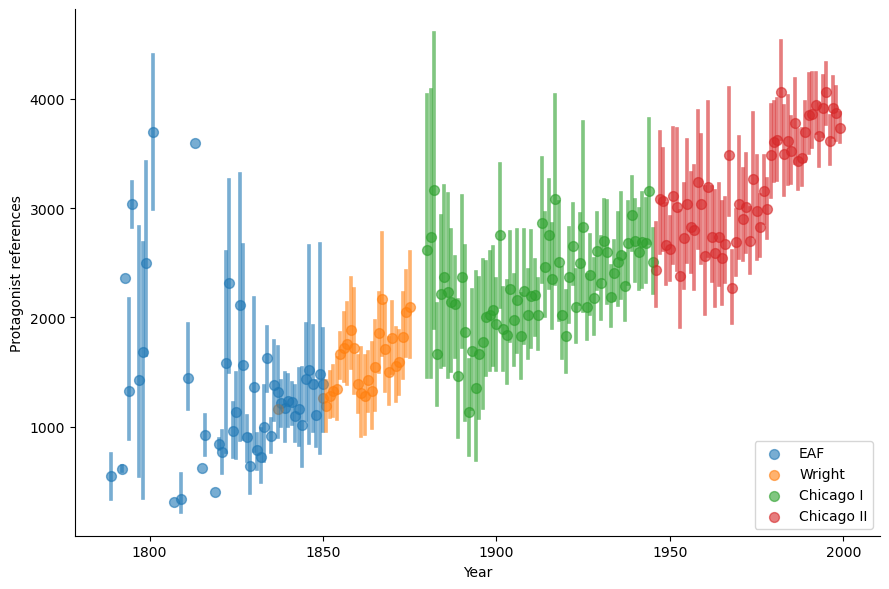

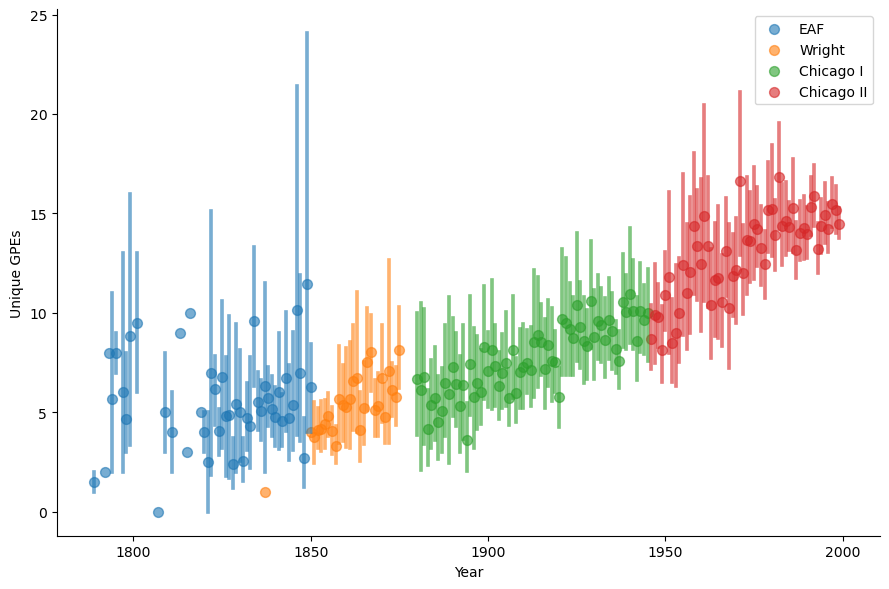

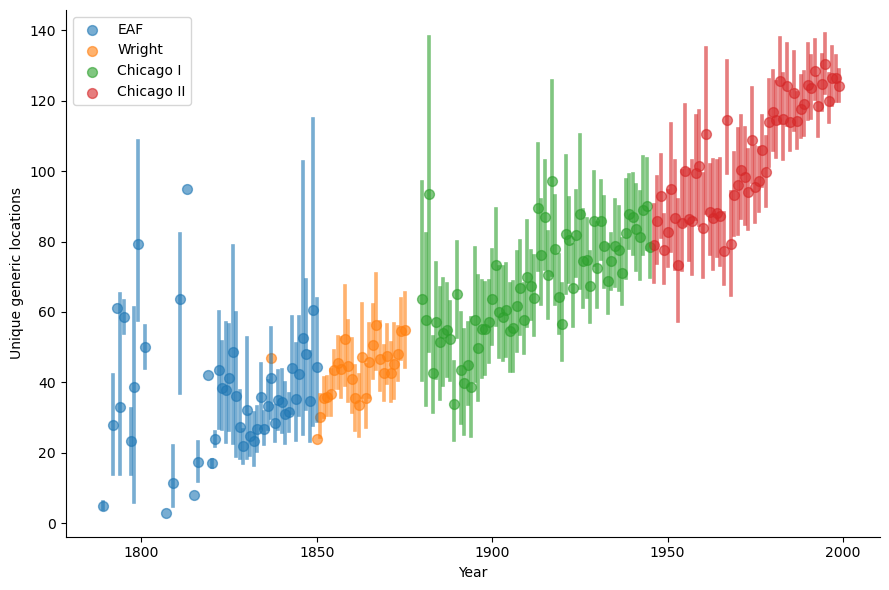

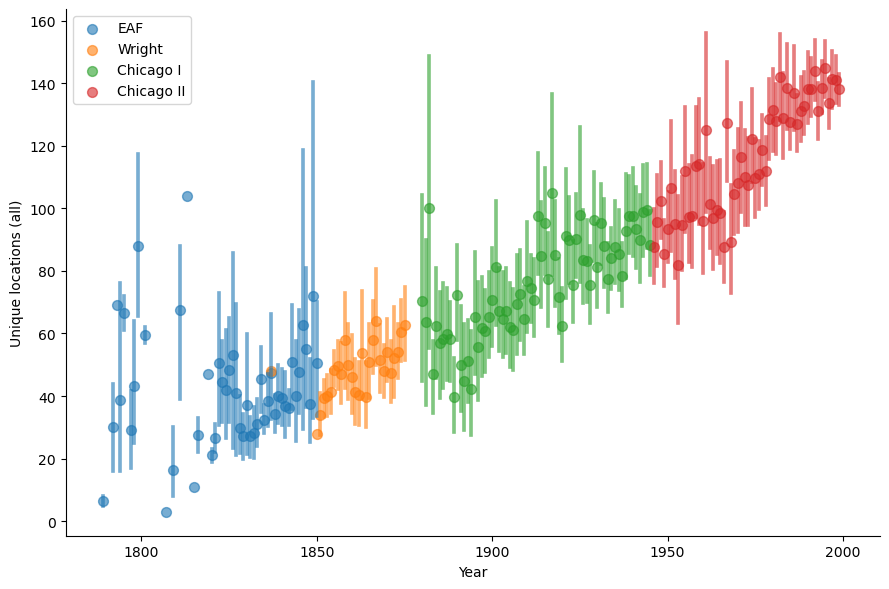

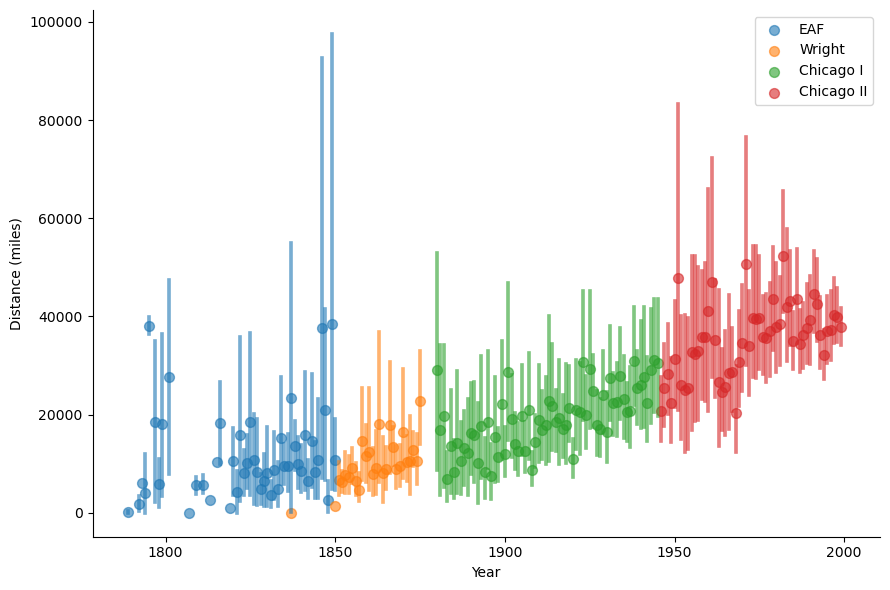

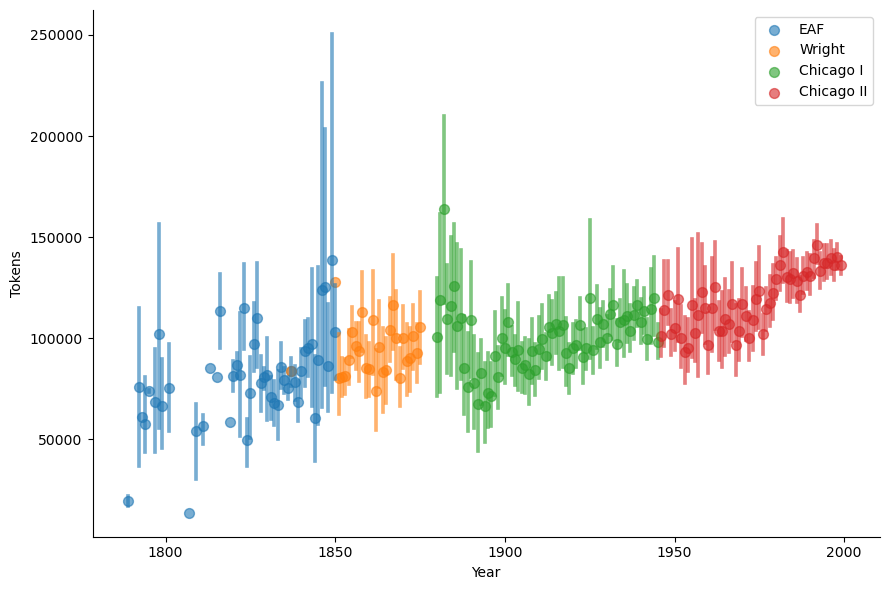

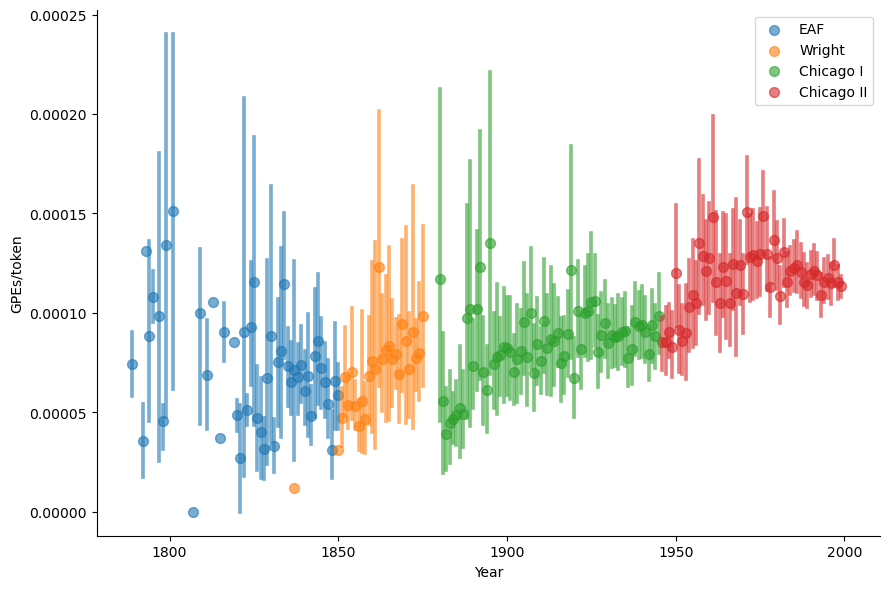

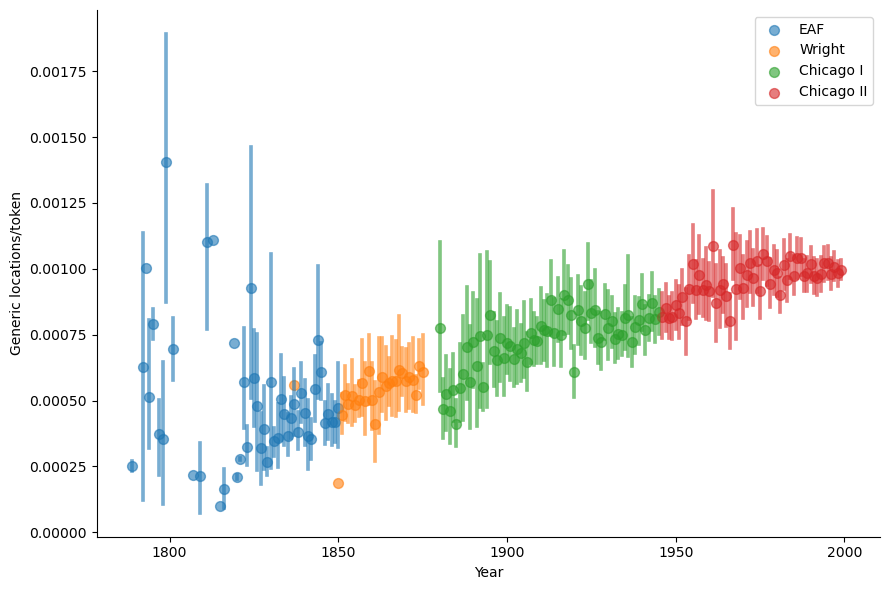

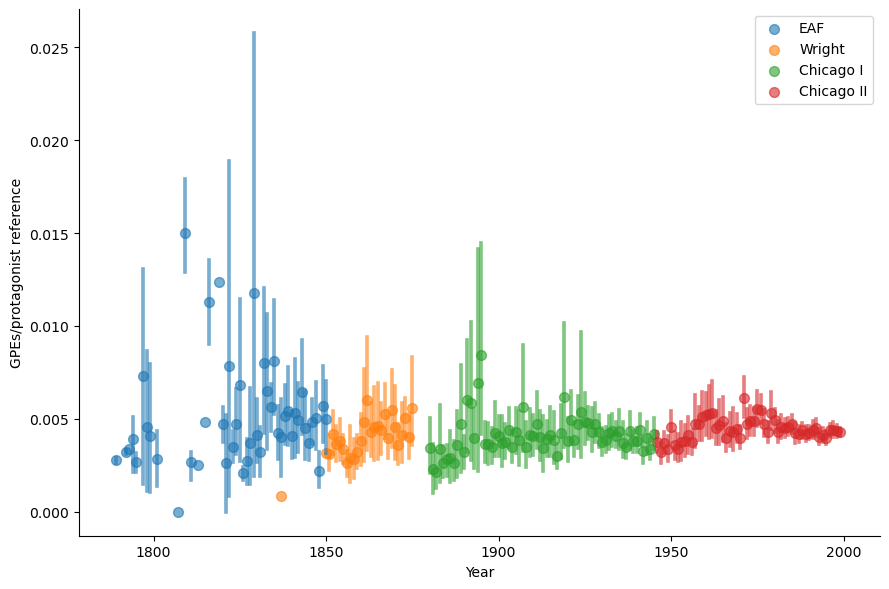

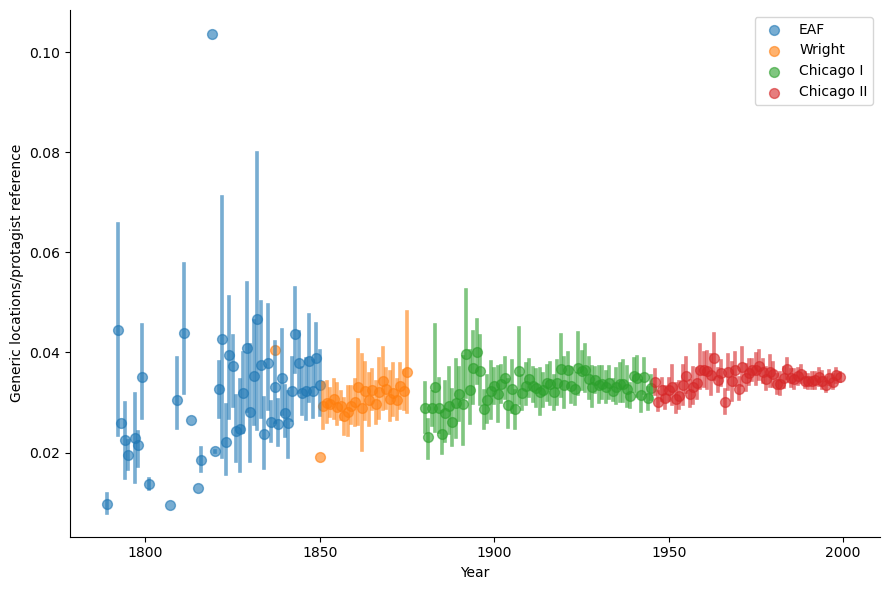

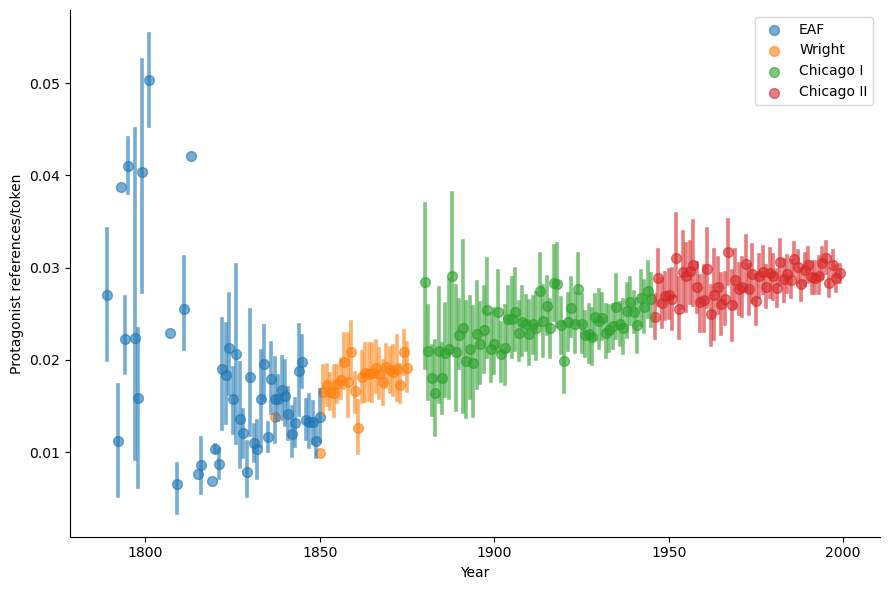

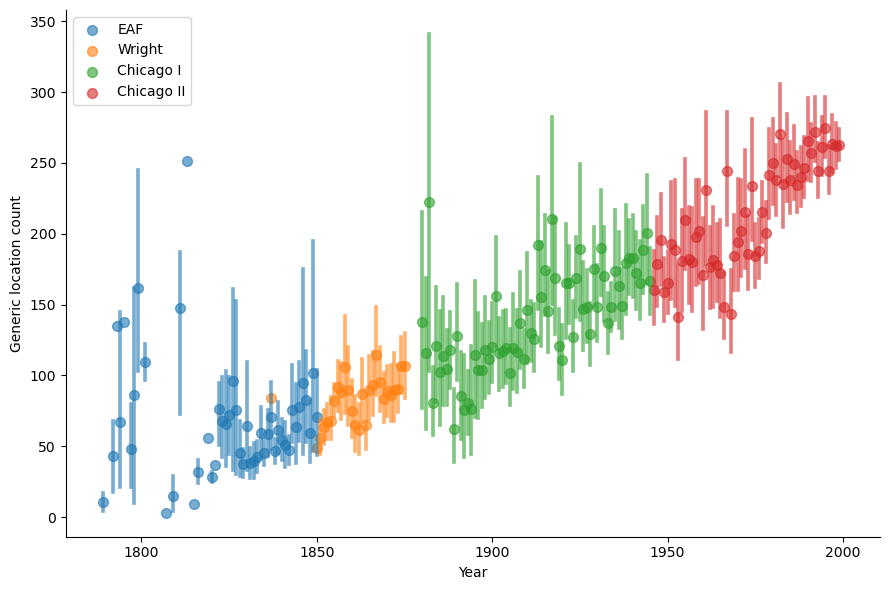

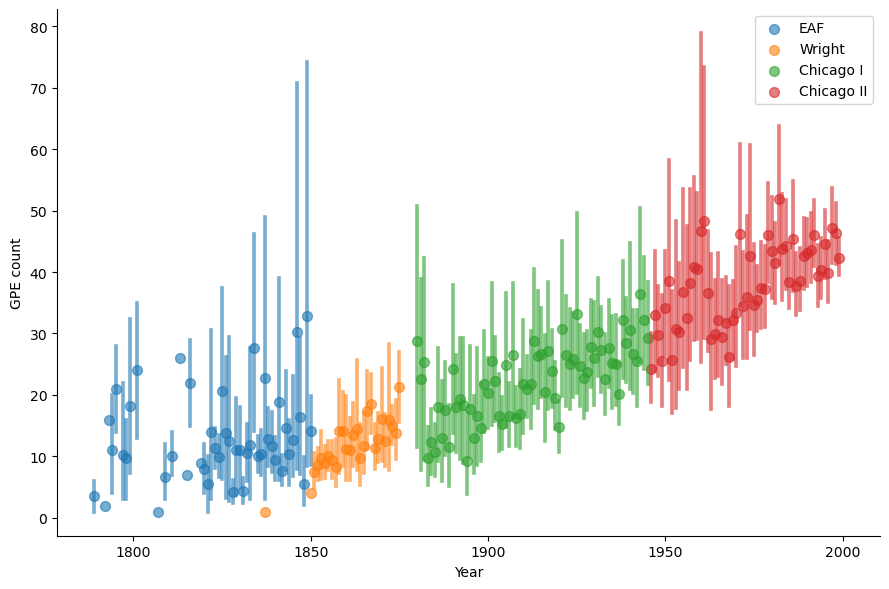

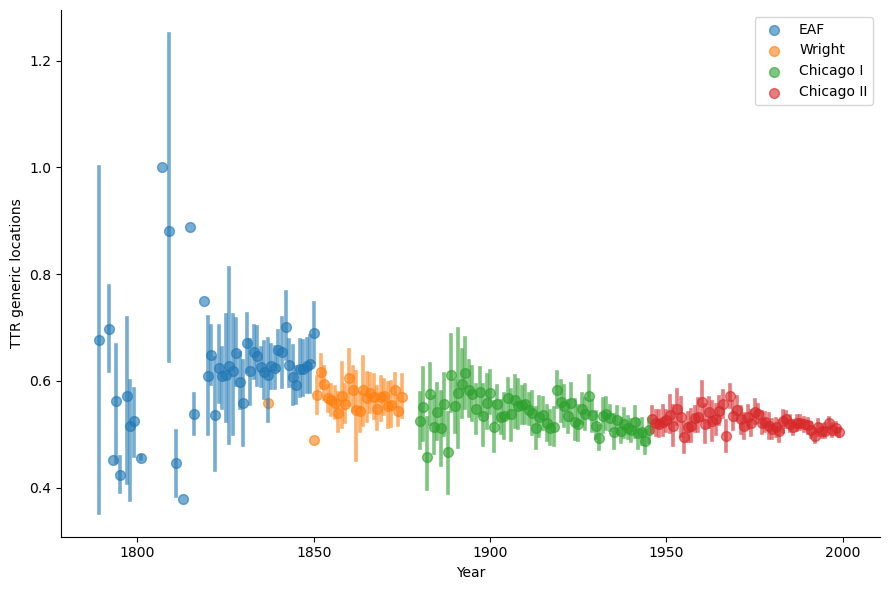

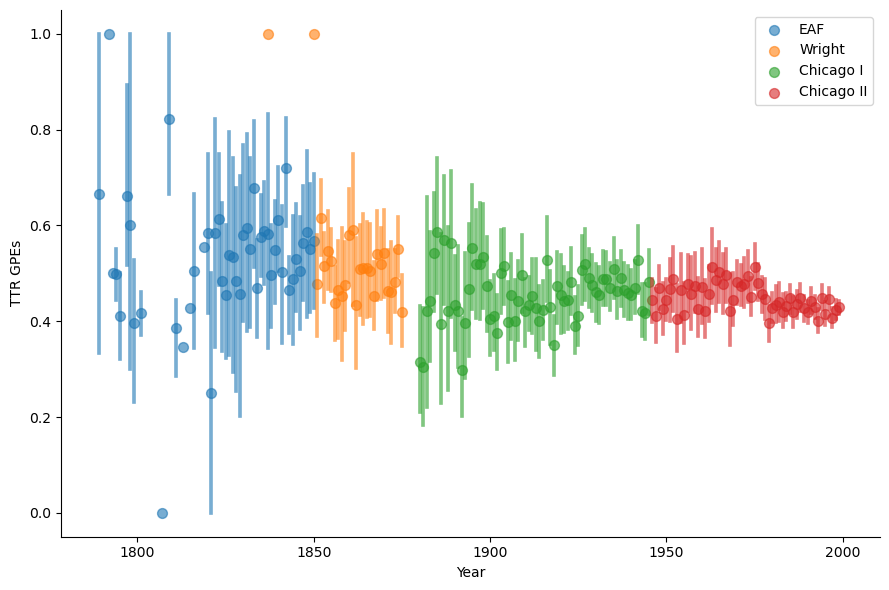

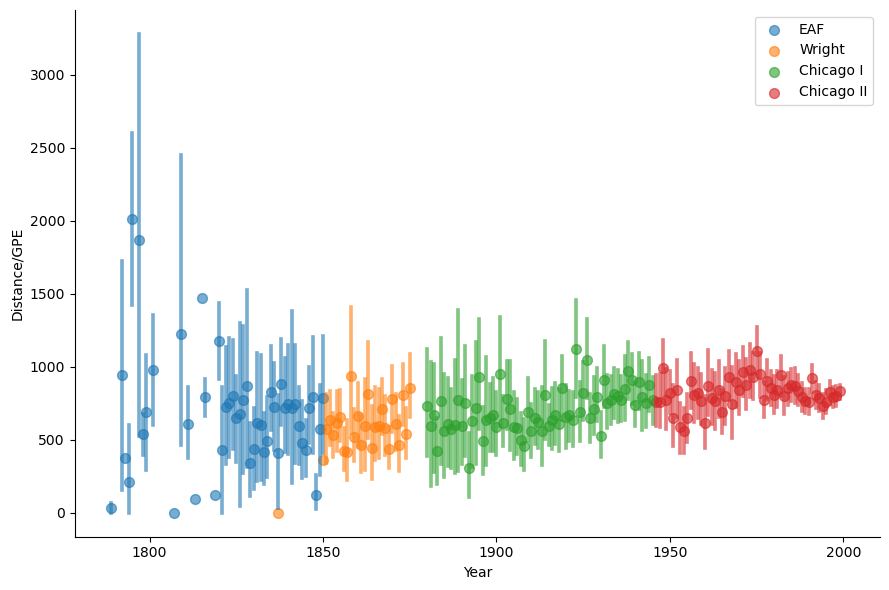

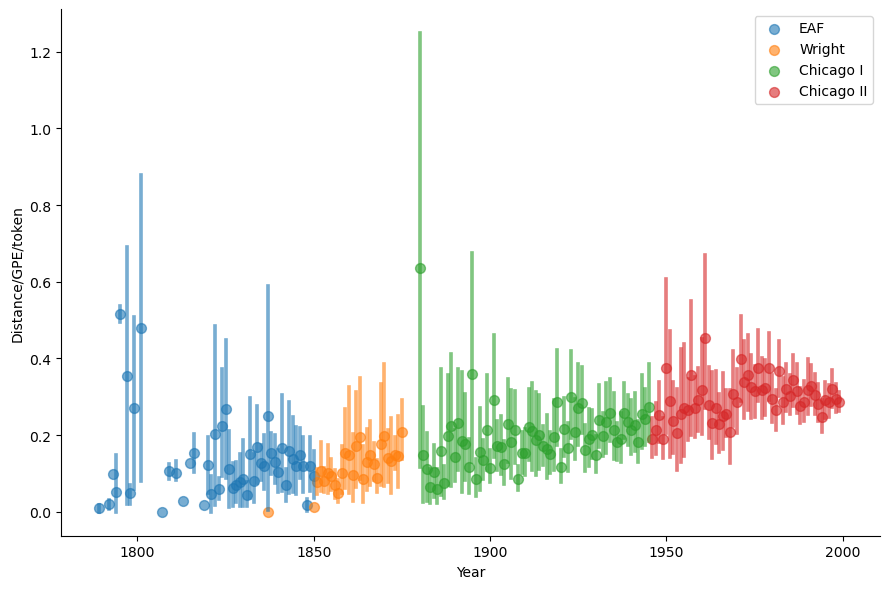

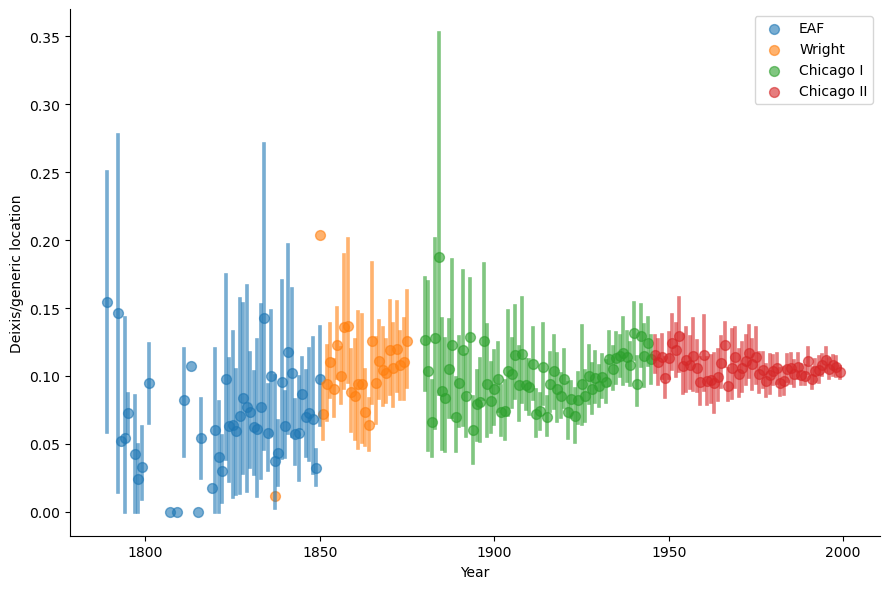

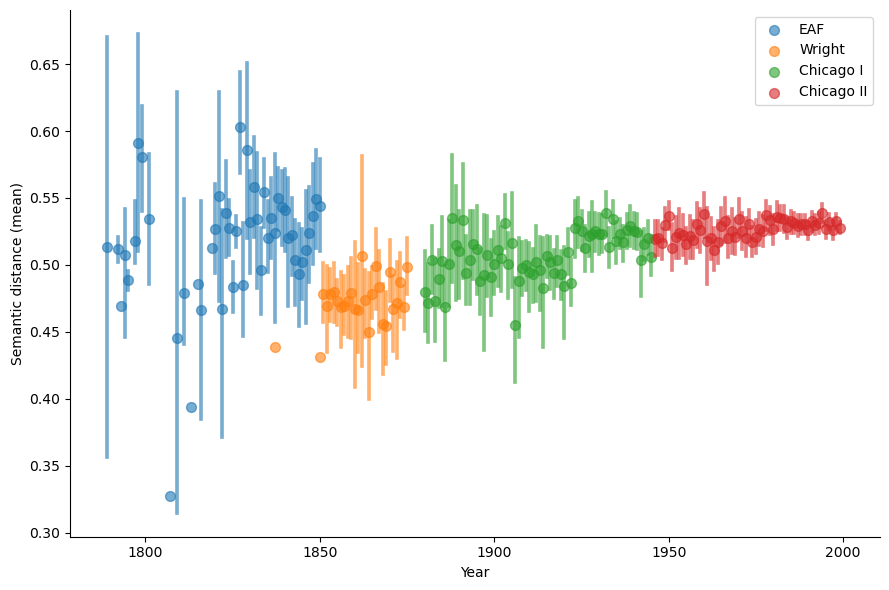

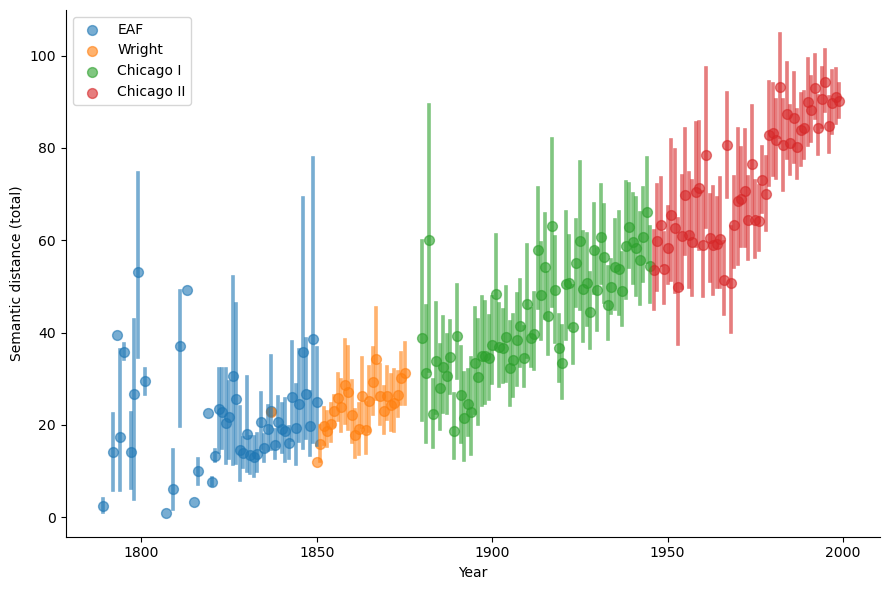

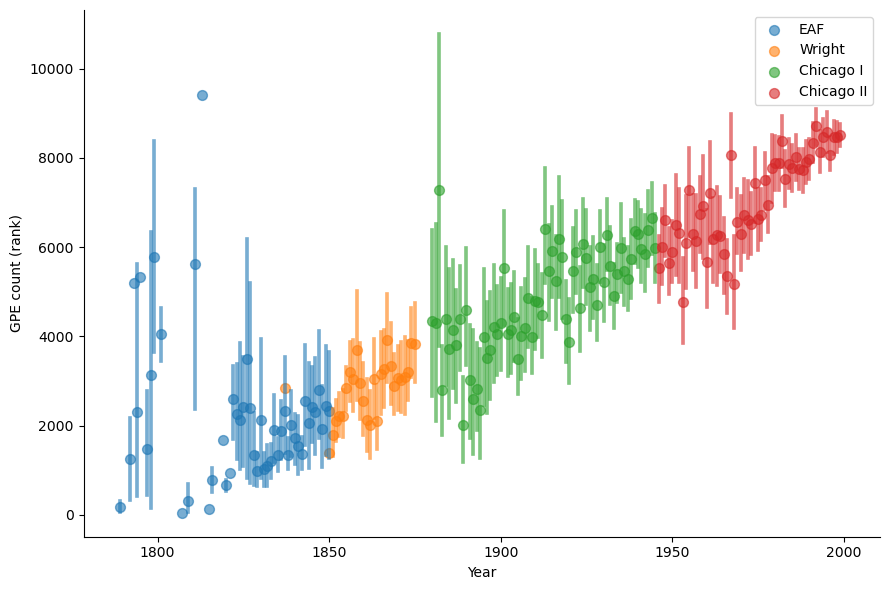

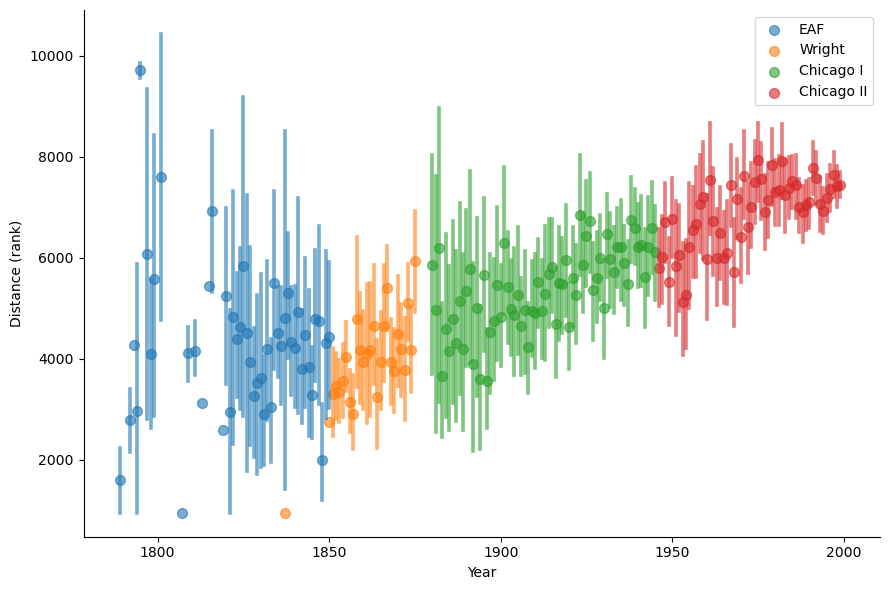

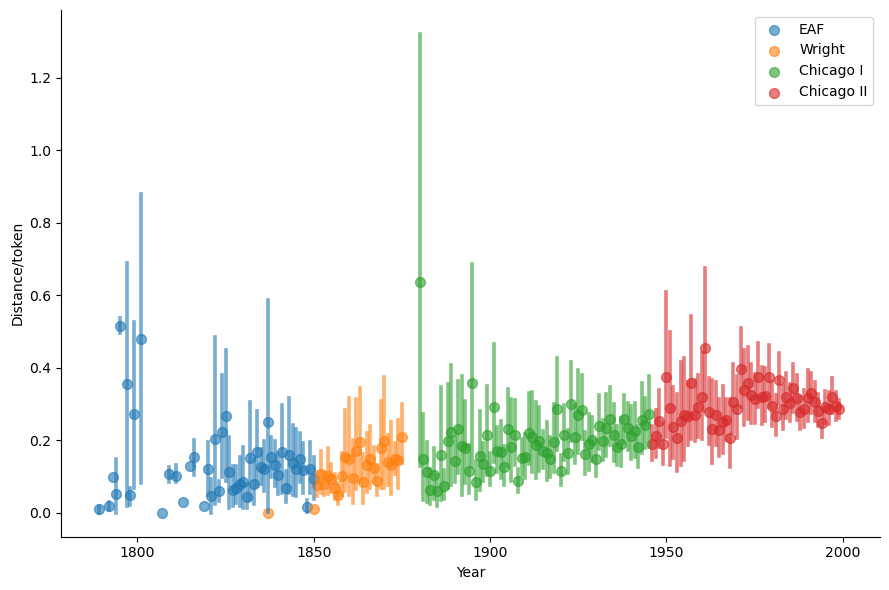

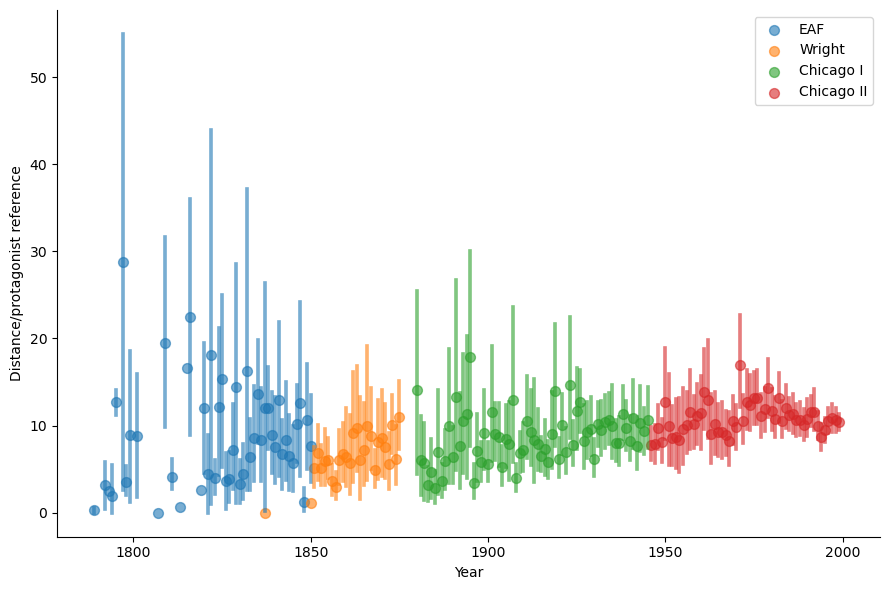

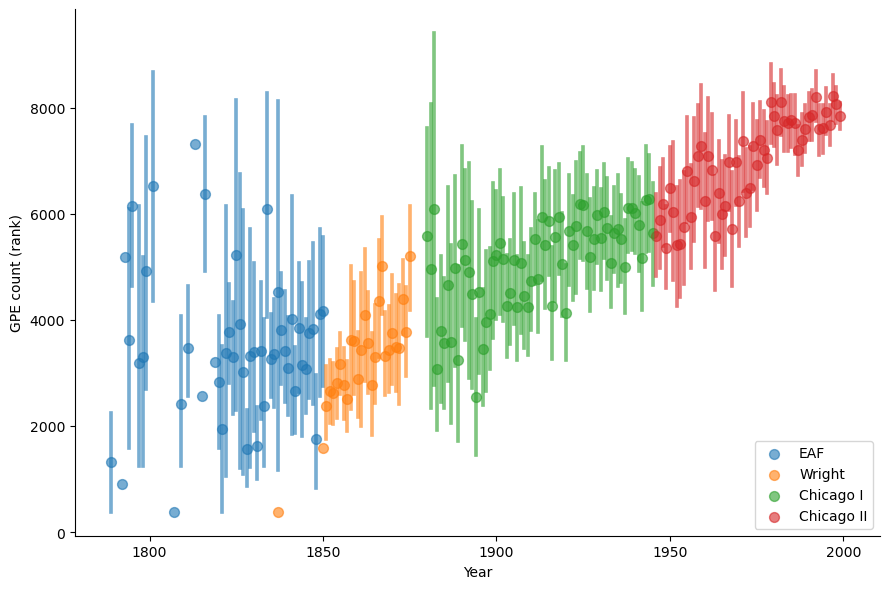

In [15]:
# create plots
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = np.arange(fic_data.pub_date.min(), fic_data.pub_date.max(), 1)
    for col in numeric_cols:
        sns.lmplot(
            x='pub_date', 
            y=col, 
            data=fic_data, 
            #y_partial='Category', # control for fiction/nonfiction
            fit_reg=False,
            x_bins=bins, #fixed total bins by year
            #x_bins=10, # number of bins per collection
            hue='collection',
            hue_order=['EAF', 'Wright', 'Chicago I', 'Chicago II'],
            legend=False,
            height=6,
            aspect=1.5,
            scatter_kws={'alpha':0.6}
        )
        plt.xlabel('Year')
        plt.ylabel(feature_labels[col])
        plt.legend(loc='best')
        plt.tight_layout()
        for ext in vis_formats:
            plt.savefig(
                os.path.join(
                    fig_dir, 
                    'historical_change',
                    f'historical_change_{col}_fiction_by_collection.'+ext
                ), 
                dpi=300
            )
        plt.show()

### Facet by character gender

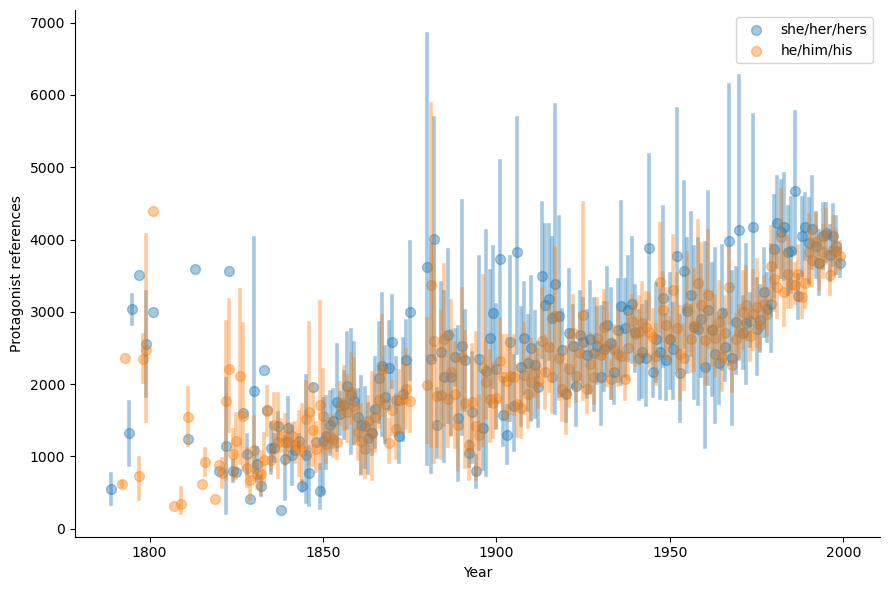

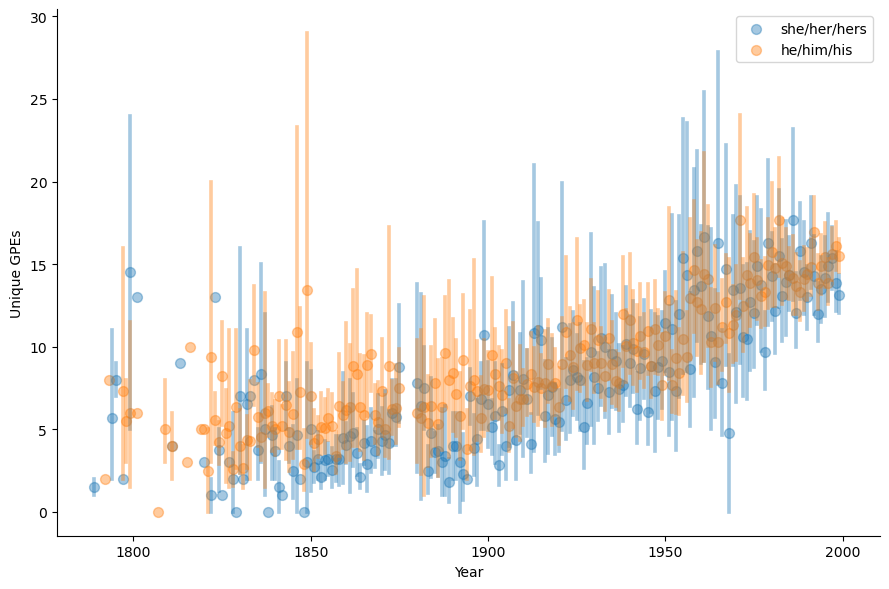

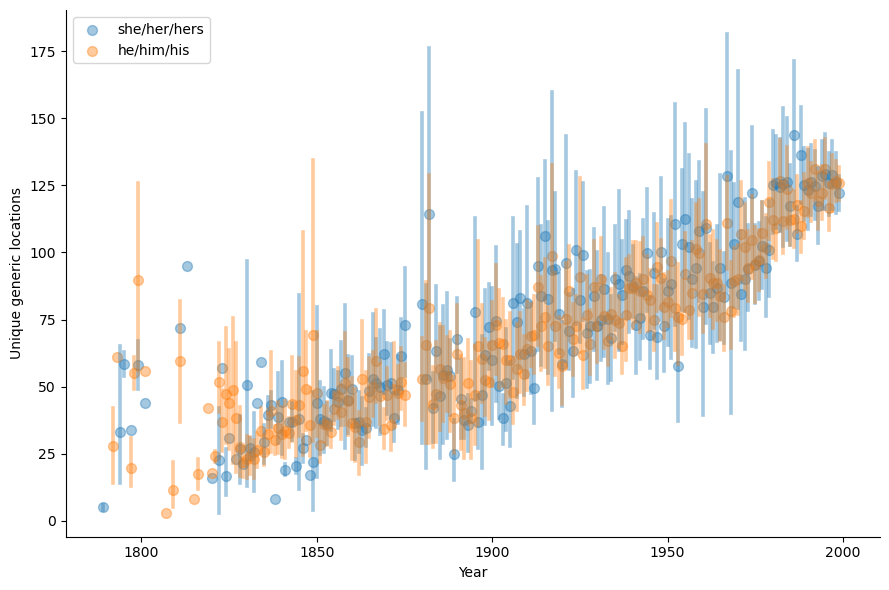

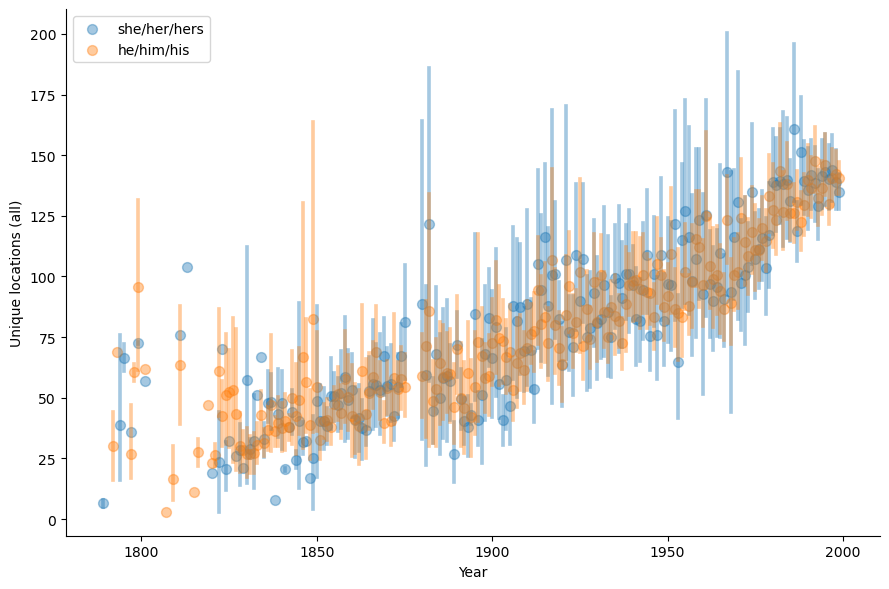

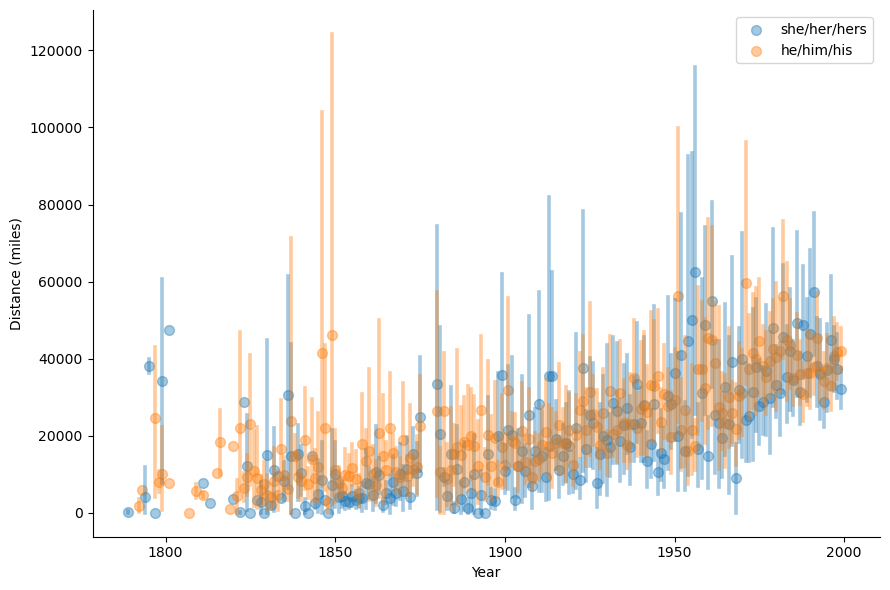

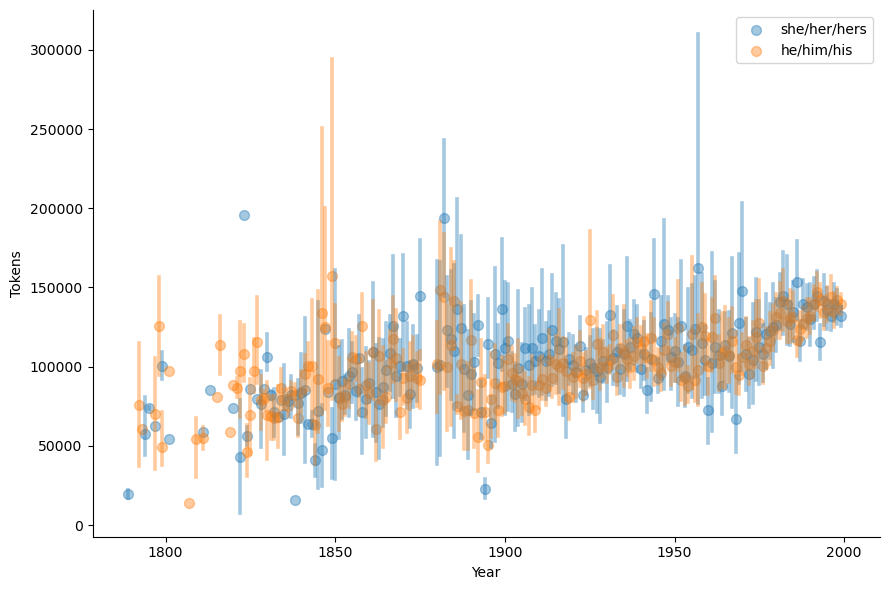

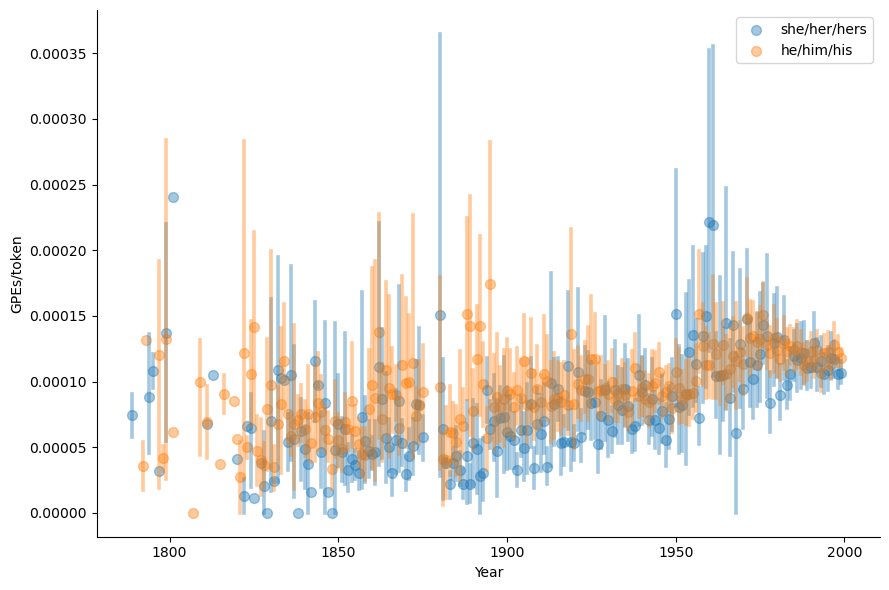

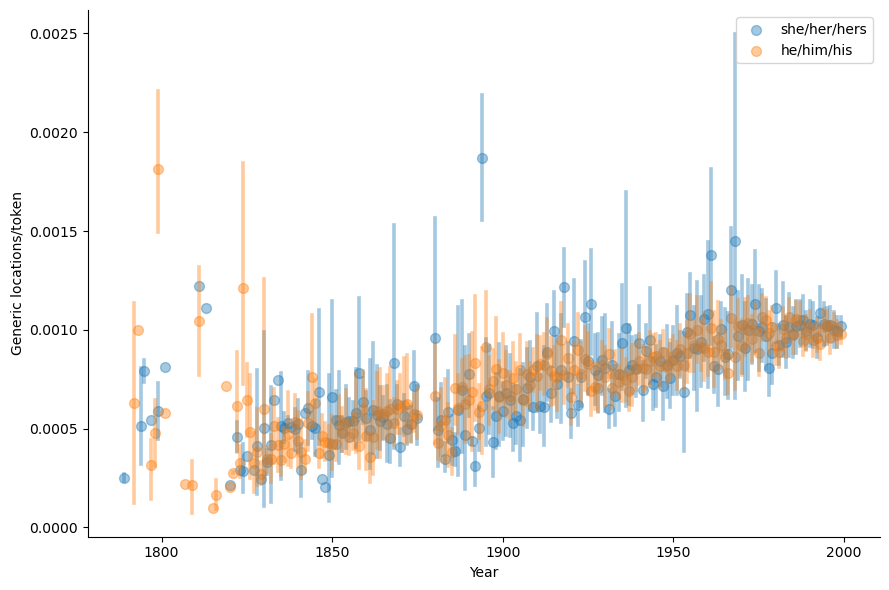

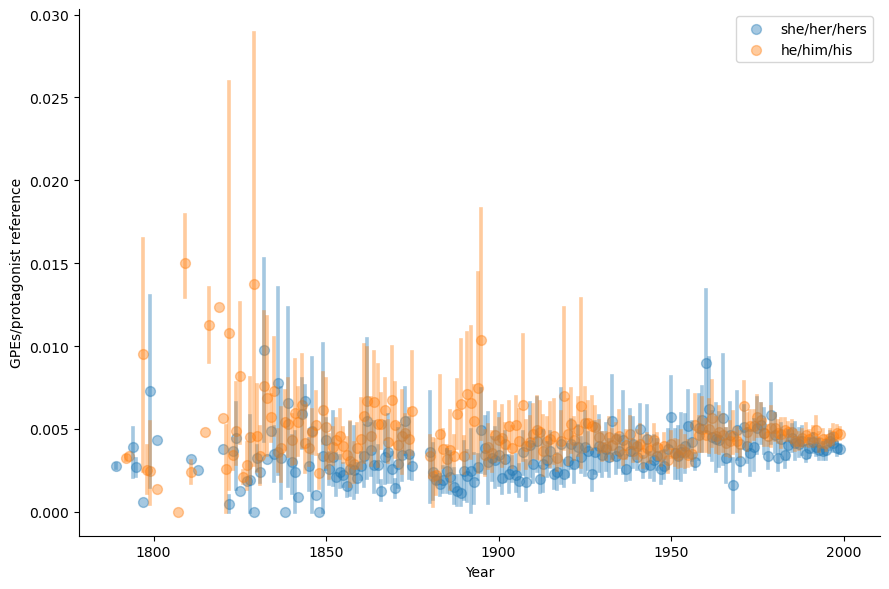

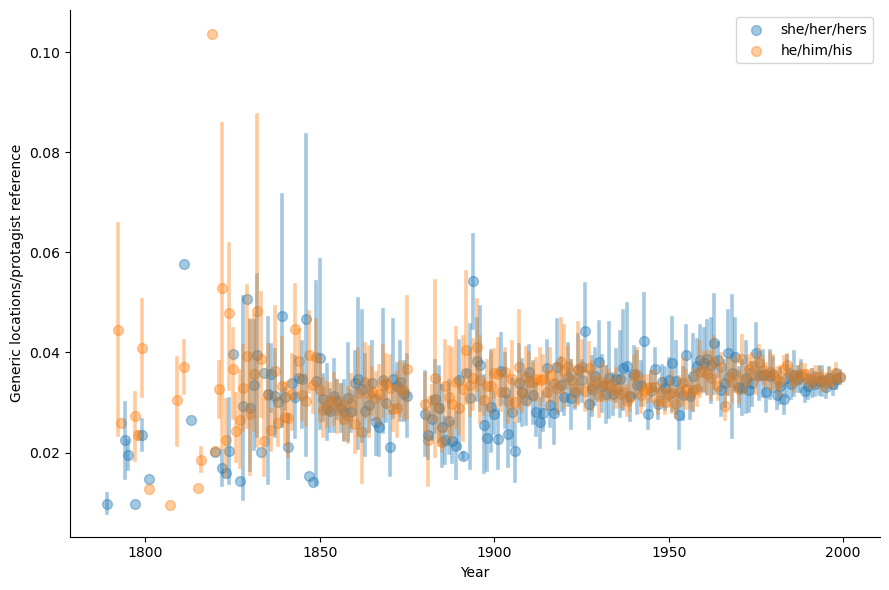

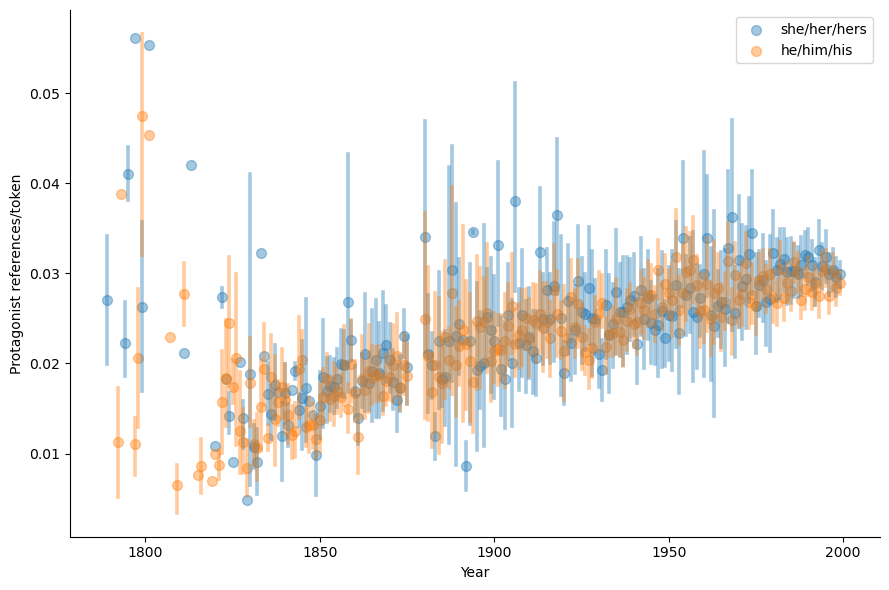

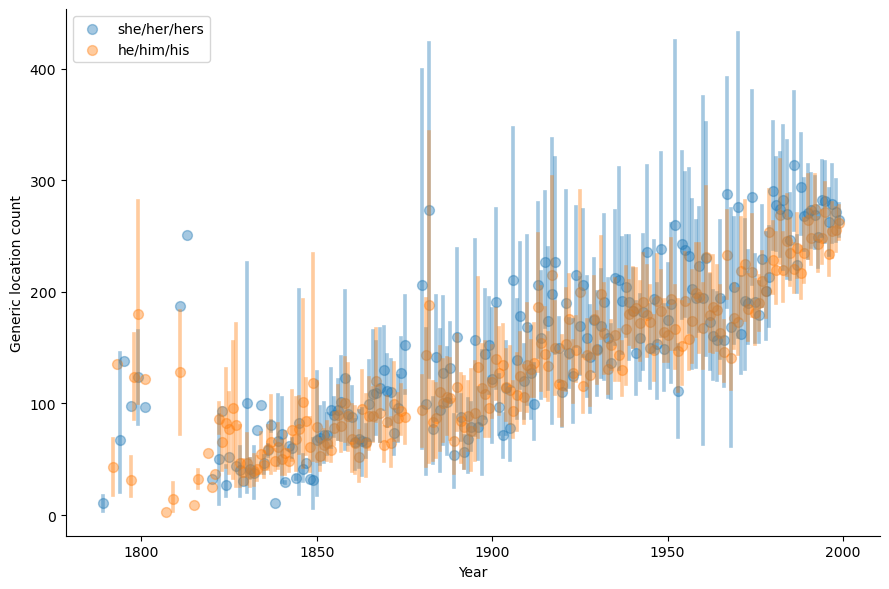

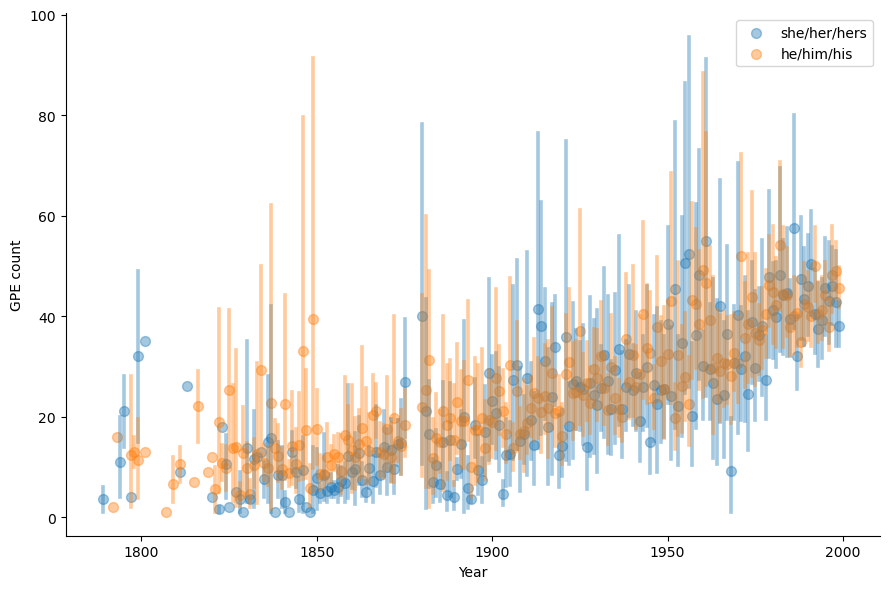

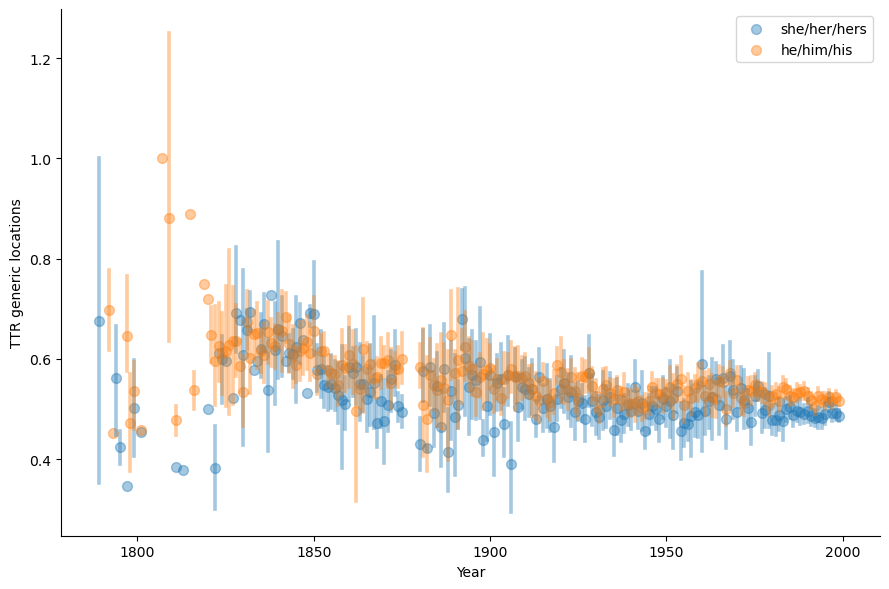

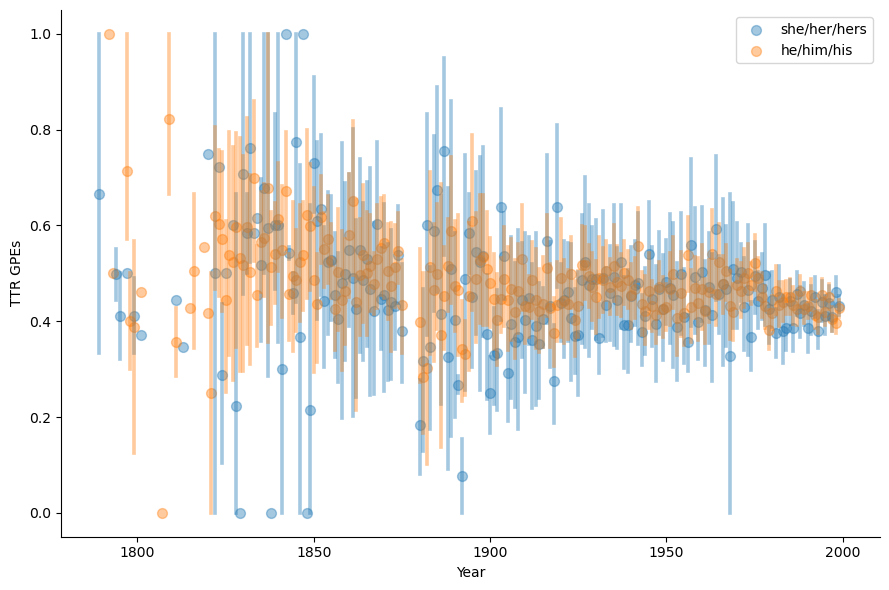

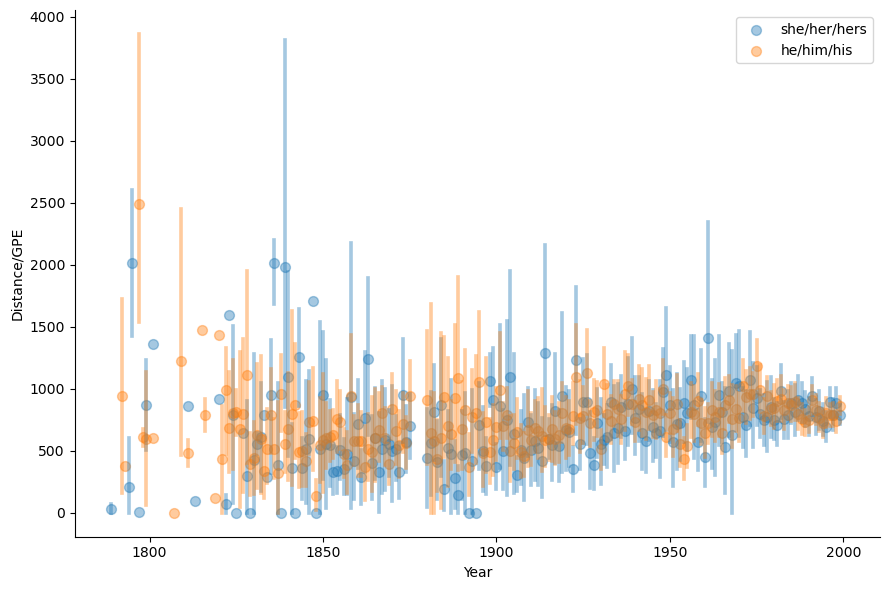

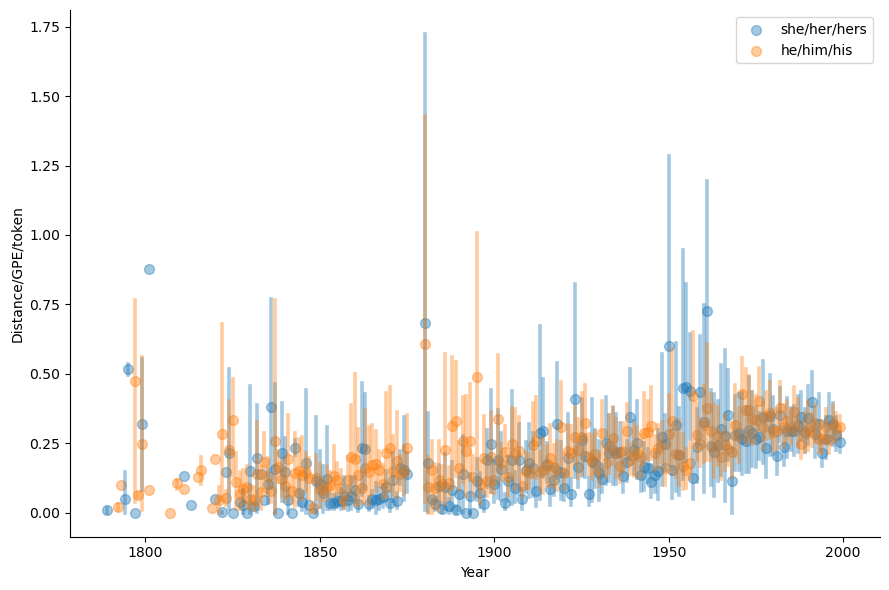

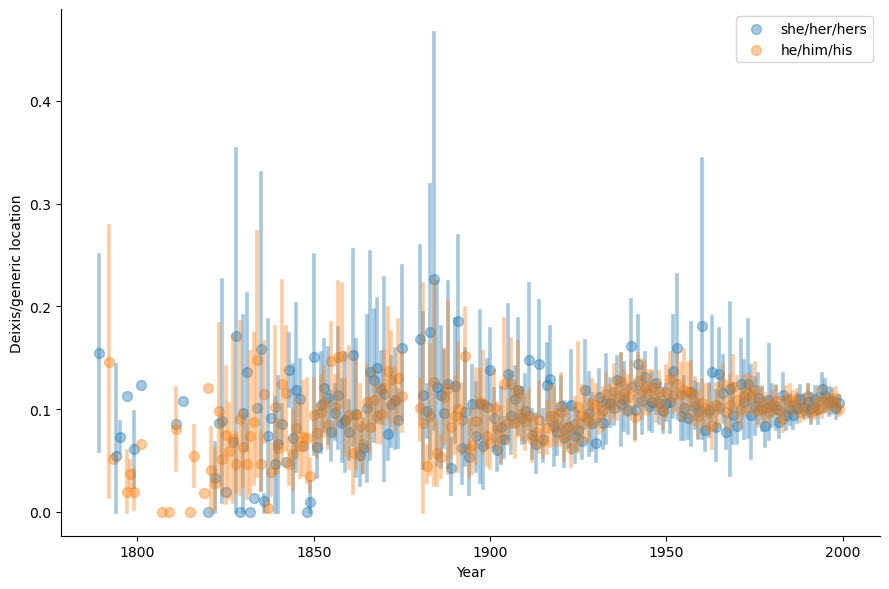

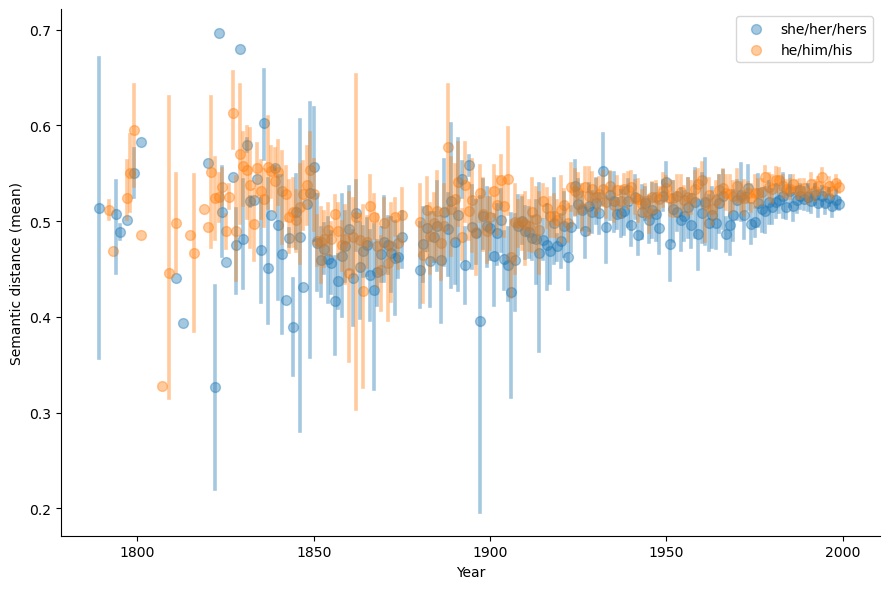

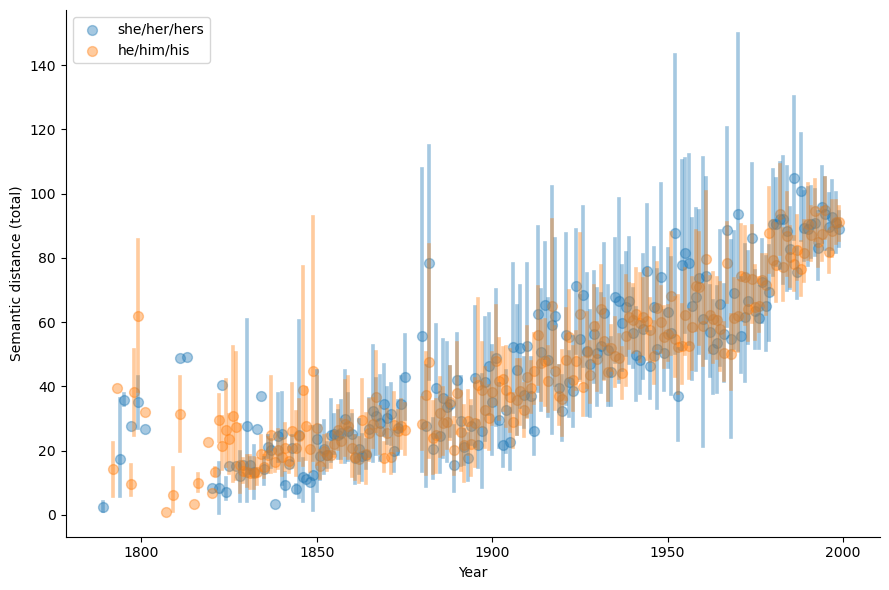

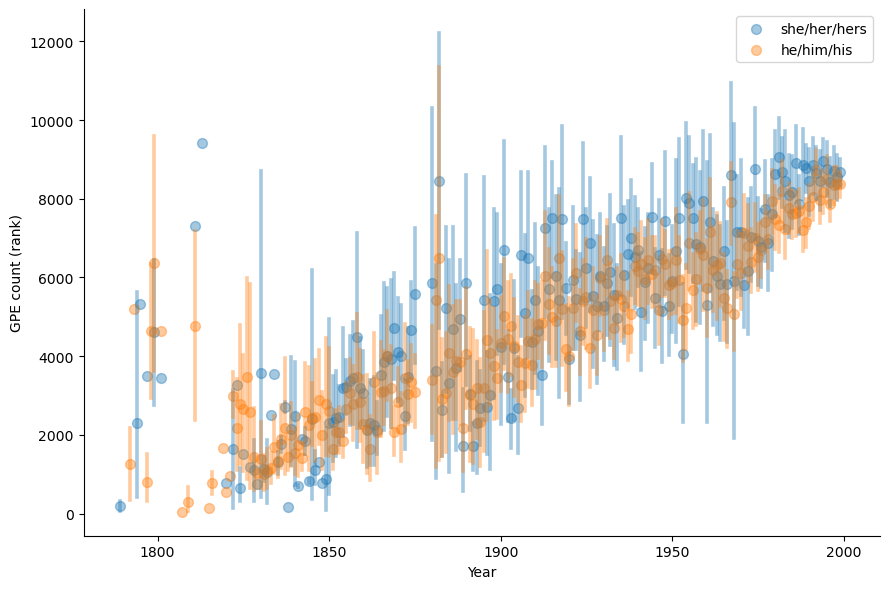

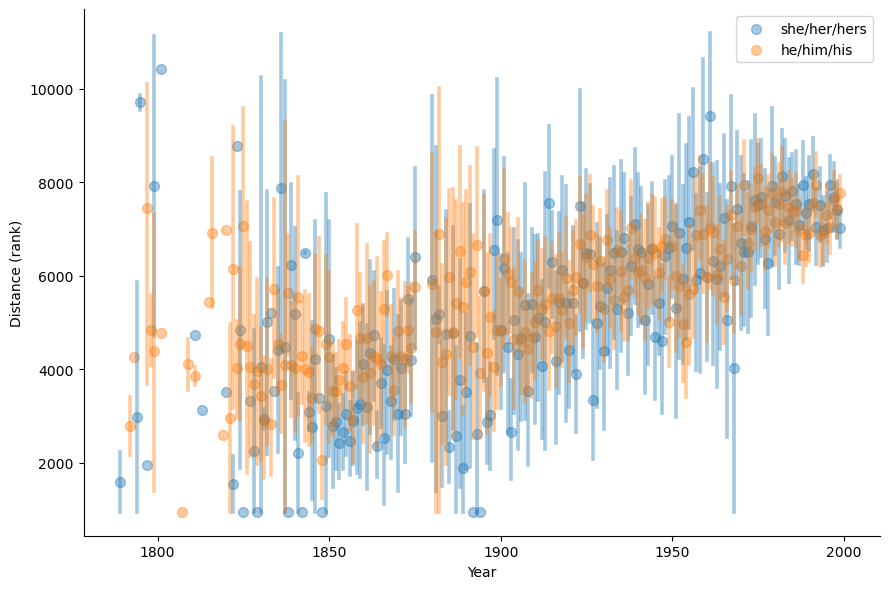

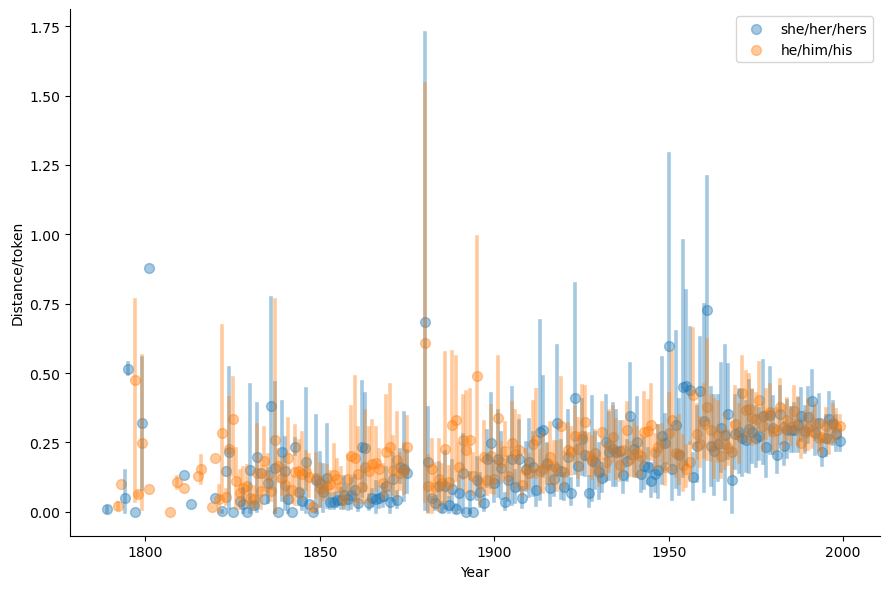

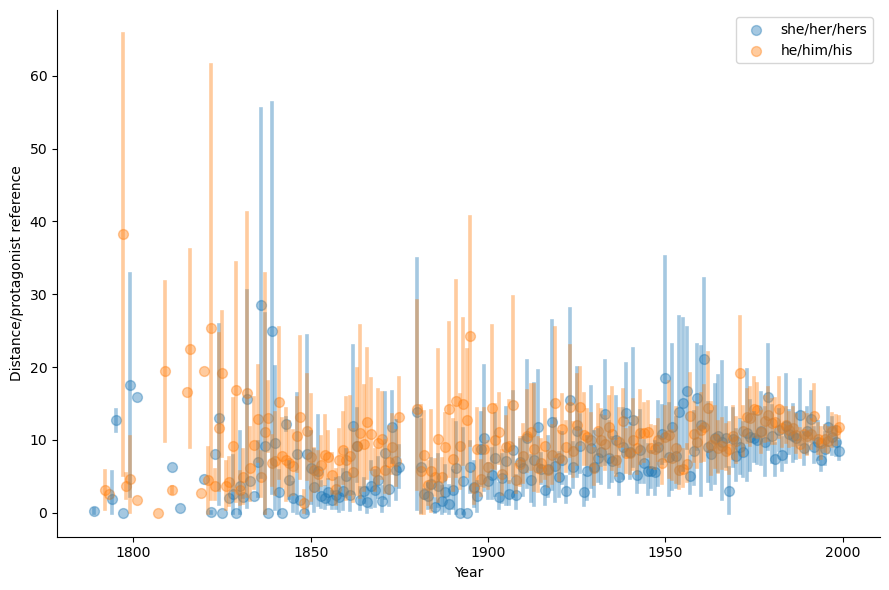

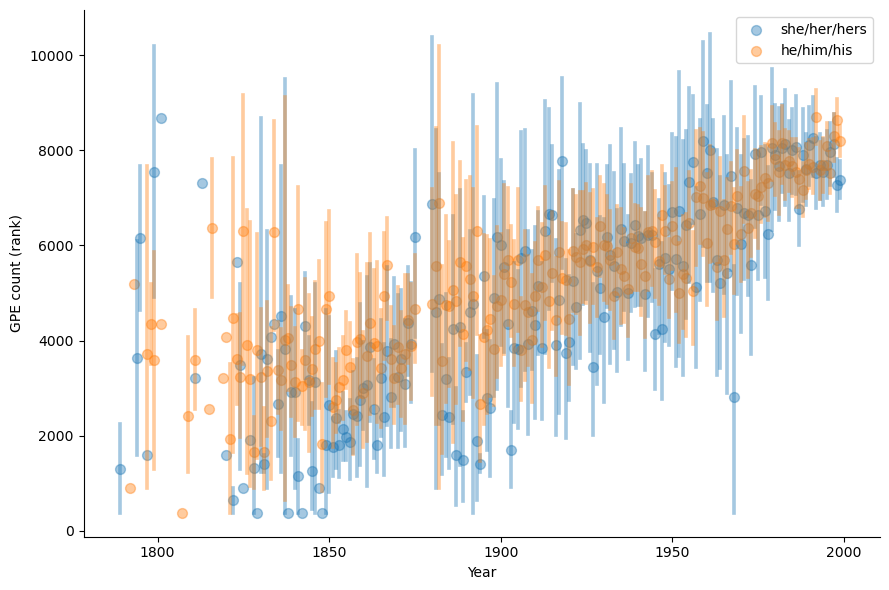

In [16]:
# create plots
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fic_data_gender_limited = fic_data.loc[fic_data.inf_gender.isin(['she/her/hers', 'he/him/his'])]
    bins = np.arange(fic_data.pub_date.min(), fic_data.pub_date.max(), 1)
    for col in numeric_cols:
        sns.lmplot(
            x='pub_date', 
            y=col, 
            data=fic_data_gender_limited, 
            fit_reg=False,
            x_bins=bins, #fixed total bins by year
            hue='inf_gender',
            legend=False,
            height=6,
            aspect=1.5,
            scatter_kws={'alpha':0.4}
        )
        plt.xlabel('Year')
        plt.ylabel(feature_labels[col])
        plt.legend(loc='best')
        plt.tight_layout()
        for ext in vis_formats:
            plt.savefig(
                os.path.join(
                    fig_dir, 
                    'historical_change', 
                    f'historical_change_{col}_fiction_by_char_gender.'+ext
                ), 
                dpi=300
            )
        plt.show()

## Misc. calculations

Some specific things to investigate for the article.

In [17]:
# mean distance by century
print(f'Mean distance C19: {fic_data.loc[(fic_data.pub_date>=1800) & (fic_data.pub_date<1900)].dist_miles.mean():0.1f}')
print(f'Mean distance C20: {fic_data.loc[(fic_data.pub_date>=1900) & (fic_data.pub_date<2000)].dist_miles.mean():0.1f}')
print(f'Mean distance C21: {conlit.loc[conlit.Category=="FIC"].dist_miles.mean():0.1f}')

Mean distance C19: 11781.5
Mean distance C20: 32915.9
Mean distance C21: 38024.1


In [18]:
# mean unique GPEs by century
print(f'Mean total GPEs C19: {fic_data.loc[(fic_data.pub_date>=1800) & (fic_data.pub_date<1900)].gpe_places_total.mean():0.2f}')
print(f'Mean total GPEs C20: {fic_data.loc[(fic_data.pub_date>=1900) & (fic_data.pub_date<2000)].gpe_places_total.mean():0.2f}')
print(f'Mean total GPEs C21: {conlit.loc[conlit.Category=="FIC"].gpe_places_total.mean():0.2f}')

Mean total GPEs C19: 13.49
Mean total GPEs C20: 36.19
Mean total GPEs C21: 38.89


In [19]:
# ditto, by corpus
data.loc[data.Category=='FIC', ['dist_miles', 'gpe_places_total', 'collection']].groupby('collection').mean().round(1)

dist_miles  gpe_places_total
collection                              
CONLIT         38024.1              38.9
Chicago I      21026.0              24.4
Chicago II     37023.2              40.3
EAF            13139.2              13.9
Wright         10476.9              12.4

In [21]:
# start-finish results

# limit to volumes with well-defined z-scores, eliminate far outliers
facet_by = ['Category', 'inf_gender', 'author_gender', 'perspective', 'Genre']
df = data.loc[((data.num_gpe_places>3) & (data.dist_miles>0) & (~data.Start_Finish_Z.isna()) & (data.Start_Finish_Z.between(-10,10))), 
    facet_by+['Start_Finish_Z', 'Start_Finish_Miles', 'collection']]

# summary stats
df.describe()

Start_Finish_Z  Start_Finish_Miles
count     8093.000000         8093.000000
mean         0.003152         2317.176105
std          1.459015         2386.247336
min         -9.819165            0.000000
25%         -0.883566          332.020213
50%         -0.196435         1404.766175
75%          0.940434         3884.674423
max          9.575902        11737.182620

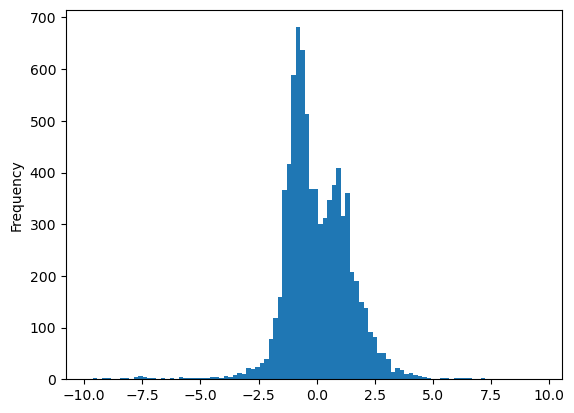

In [22]:
# histogram of start-finish z-scores
df.Start_Finish_Z.plot(kind='hist', bins=100);

In [23]:
# compare start-finish results by facet
print('======================\n======================\n   *** CONLIT ***\n======================\n======================')
compare_facets(
    df=df.loc[df.collection=='CONLIT'], 
    facets=facet_by,
    cols_to_drop=[],
    statistic=diff_means
)

print('\n\n======================\n======================\n   *** EARLY ***\n======================\n======================')
facet_by = ['inf_gender', 'author_gender', 'perspective']
compare_facets(
    df=df.loc[df.collection!='CONLIT'], 
    facets=facet_by,
    cols_to_drop=[],
    statistic=diff_means
)

   *** CONLIT ***

Facet: Category


FIC          NON       diff         p sig
Start_Finish_Z        -0.203488    -0.159200  -0.044288  0.493403    
Start_Finish_Miles  2073.354119  1983.933118  89.421001  0.406238


Facet: inf_gender


she/her/hers   he/him/his        diff         p sig
Start_Finish_Z         -0.203730    -0.204415    0.000685  0.982007    
Start_Finish_Miles   2136.237556  2028.162184  108.075372  0.395042


Facet: author_gender


F            M        diff         p sig
Start_Finish_Z        -0.172947    -0.239175    0.066228  0.394242    
Start_Finish_Miles  2016.792824  2129.891069 -113.098245  0.365454


Facet: perspective


other        first       diff         p sig
Start_Finish_Z        -0.200348    -0.205833   0.005484  0.946022    
Start_Finish_Miles  2077.982217  2060.084556  17.897661  0.885246


Facet: Genre


YA       others        diff         p sig
Start_Finish_Z        -0.430460    -0.179701   -0.250759  0.065574    
Start_Finish_Miles  1588.701042  2118.249710 -529.548667  0.011196   *

SF       others        diff         p  sig
Start_Finish_Z        -0.098652    -0.215135    0.116483  0.346261     
Start_Finish_Miles  2753.108619  1990.705924  762.402695  0.000800  ***

BS       others        diff         p sig
Start_Finish_Z        -0.263504    -0.193083   -0.070421  0.538185    
Start_Finish_Miles  1891.492370  2098.385703 -206.893334  0.235906

NYT       others       diff         p sig
Start_Finish_Z        -0.175837    -0.211401   0.035565  0.713315    
Start_Finish_Miles  2122.078055  2052.594543  69.483512  0.643743

MY       others        diff         p sig
Start_Finish_Z        -0.119367    -0.215966    0.096599  0.419032    
Start_Finish_Miles  1945.386492  2087.208825 -141.822333  0.411036

ROM       others       diff         p sig
Start_Finish_Z        -0.112365    -0.212730   0.100365  0.461415    
Start_Finish_Miles  2037.896572  2071.729333 -33.832762  0.863655

PW       others        diff         p sig
Start_Finish_Z        -0.092036    -0.221711    0.129674  0.227109    
Start_Finish_Miles  2332.954576  2024.622927  308.331649  0.090364

MID       others        diff         p sig
Start_Finish_Z        -0.566110    -0.179362   -0.386749  0.017593   *
Start_Finish_Miles  1580.952294  2100.622037 -519.669743  0.039984   *



   *** EARLY ***

Facet: inf_gender


she/her/hers   he/him/his       diff         p sig
Start_Finish_Z          0.089316     0.082747   0.006569  0.899640    
Start_Finish_Miles   2378.173996  2454.428518 -76.254523  0.273491


Facet: author_gender


M            F       diff         p sig
Start_Finish_Z         0.078390     0.101198  -0.022807  0.573371    
Start_Finish_Miles  2460.057117  2381.659274  78.397843  0.223111


Facet: perspective


other        first        diff         p sig
Start_Finish_Z         0.099696     0.064862    0.034834  0.379848    
Start_Finish_Miles  2472.944305  2364.844403  108.099901  0.090364

## Examine specific books and authors

In [24]:
# Read metadata
conlit_meta = pd.read_csv(os.path.join(metadata_dir, conlit_meta_file), index_col='ID').fillna('')
early_meta = pd.read_csv(os.path.join(metadata_dir, early_meta_file), index_col='book_id', sep='\t').fillna('')

In [25]:
# reference points
print("Median distance:", data.dist_miles.median())
print("Median numbers GPEs:", data.num_gpe_places.median())

Median distance: 15731.3846661428
Median numbers GPEs: 9.0


In [26]:
# Tolkien
early_meta.loc[early_meta.author.str.startswith('Tolkien'), ['author', 'title']].join(data[['dist_miles', 'num_gpe_places']])

author       title  dist_miles  num_gpe_places
book_id                                                            
00011059  Tolkien, J. R. R.  The Hobbit         0.0               4

In [27]:
# Any Weir, The Martian
data.loc[data.index.str.contains('TheMartian'), ['dist_miles', 'num_gpe_places']]

dist_miles  num_gpe_places
book_id                                                  
2011_Weir,Andy_TheMartian_SF  9412.553779              16

In [28]:
# Kim Stanley Robinson
display(data.loc[data.index.str.contains('Robinson,Kim'), ['dist_miles', 'num_gpe_places']])
display(early_meta.loc[early_meta.author.str.startswith('Robinson, Kim'), ['author', 'title']].join(data[['dist_miles', 'num_gpe_places']]))

dist_miles  num_gpe_places
book_id                                                         
2012_Robinson,KimStanley_2312_SF    80167.045869              29
2013_Robinson,KimStanley_Shaman_SF      0.000000               1

author                    title    dist_miles  \
book_id                                                                  
00024103  Robinson, Kim Stanley               Green mars  19640.685969   
00023417  Robinson, Kim Stanley             Pacific edge  90421.740009   
00022417  Robinson, Kim Stanley  The memory of whiteness  29284.568645   
00022260  Robinson, Kim Stanley           The Wild Shore  51666.671513   
00022956  Robinson, Kim Stanley           The Gold Coast  91512.217820   
00023180  Robinson, Kim Stanley    Escape from Kathmandu  45137.422620   
00024406  Robinson, Kim Stanley                Blue Mars  57549.459250   
00023967  Robinson, Kim Stanley                 Red Mars  26193.381240   

          num_gpe_places  
book_id                   
00024103              24  
00023417              19  
00022417              16  
00022260              21  
00022956              22  
00023180              23  
00024406              26  
00023967              18

In [29]:
# George R. R. Martin
display(early_meta.loc[early_meta.author.str.startswith('Martin, George R'), ['author', 'title']].join(data[['dist_miles', 'num_gpe_places']]))
display(data.loc[data.index.str.contains('Martin,George'), ['dist_miles', 'num_gpe_places']])

author               title     dist_miles  \
book_id                                                            
00024931  Martin, George R. R    A clash of kings       0.000000   
00022101  Martin, George R. R  The Armageddon rag  103221.908609   
00024359  Martin, George R. R   A game of thrones       0.000000   
00021862  Martin, George R. R           Windhaven     666.305945   
00021989  Martin, George R. R         Fevre dream   58895.552655   
00021448  Martin, George R. R  Dying of the light   35423.305181   
00022541  Martin, George R. R        Tuf voyaging    4962.360649   

          num_gpe_places  
book_id                   
00024931              10  
00022101              36  
00024359               4  
00021862              25  
00021989              26  
00021448              15  
00022541              12

dist_miles  num_gpe_places
book_id                                                            
2011_Martin,George_ADancewithDragons_BS         0.0              12